In [1]:
setwd('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.1_DescriptiveStats/Input')
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.2_Cytokine Distribution Analyses/Output')
cur_date = '112720'

library("readxl")
library(tidyverse)
library(reshape2)
library(car) #package necessary to run anova and specify type III errors
library("multcomp") #for Tukey's post hoc
library(rstatix)

#reading in file
data <- read_excel("CytokineData_102920.xlsx", sheet = 2)
data_df = data.frame(data)

#reading in demographics file
demographics_data_df = data.frame(read_excel("SubjectInfo_102920.xlsx", sheet = 2))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: mvtnorm

Warning message:
“package ‘mvtnorm’ was built under R version 4.0.3”
Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching packa

In [2]:
#adding demographics data to cytokine df
#could've made my life easier by just using full_join but didn't need every column from the demographics data set
race = c()
ethnicity = c()
sex = c()
age = c()
BMI = c()
for (i in 1:length(data_df$SubjectNo)){
    for(j in 1:length(demographics_data_df$SubjectNo)){
        if (data_df$SubjectNo[i] == demographics_data_df$SubjectNo[j]){
            race = c(race, demographics_data_df$Race[j])
            ethnicity = c(ethnicity, demographics_data_df$Ethnicity[j])
            sex = c(sex, demographics_data_df$Sex[j])
            age = c(age, demographics_data_df$Age[j])
            BMI = c(BMI, demographics_data_df$BMI[j])
        }
    }
}

data_df$Race = race
data_df$Ethnicity = ethnicity
data_df$Sex = sex
data_df$Age = age
data_df$BMI = BMI

First running "crude" model by running ANOVA to compare cytokine profiles across compartments. Then running ANCOVA to compare cytokine profiles across compartments adjusting for race and sex separately. Z-score normalizing for  cytokines (using pseudolog2 transformed concentrations).

In [3]:
head(data_df)

,Original_Identifier,Protein,Conc,Conc_pslog2,Compartment,SubjectNo,Group,SubjectID,Race,Ethnicity,Sex,Age,BMI
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,E_C_F_002,IFNg,17.642316,4.220509,ELF,1,NS,NS_1,W,NH,F,28,37.67
2,E_C_F_002,IL10,2.873724,1.953721,ELF,1,NS,NS_1,W,NH,F,28,37.67
3,E_C_F_002,IL12p70,1.625272,1.392467,ELF,1,NS,NS_1,W,NH,F,28,37.67
4,E_C_F_002,IL13,36.117692,5.214035,ELF,1,NS,NS_1,W,NH,F,28,37.67
5,E_C_F_002,IL1b,104.409217,6.719857,ELF,1,NS,NS_1,W,NH,F,28,37.67
6,E_C_F_002,IL6,21.159536,4.469856,ELF,1,NS,NS_1,W,NH,F,28,37.67


In [4]:
#making race binary between white and non-white subjects
for (i in 1:length(data_df$Race)){
    if(data_df$Race[i] != 'W'){
        data_df$Race[i] = 'NW'
    }
}

In [5]:
#scaling the concentration values by protein normalizes the distribution
scaled_data_df = data_df %>%
    group_by(Protein) %>% #this groups by compartment first
    mutate(Scaled_Concentrations = scale(Conc_pslog2)) %>%
    arrange(Compartment, Protein, SubjectID) #arranges by compartment, then protein, then subjectid
head(scaled_data_df)

Original_Identifier,Protein,Conc,Conc_pslog2,Compartment,SubjectNo,Group,SubjectID,Race,Ethnicity,Sex,Age,BMI,Scaled_Concentrations
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,"<dbl[,1]>"
E_B_M_118,Eotaxin,192.78146,7.598287,ELF,43,Ecig,43_Ecig,W,NH,M,20,32.34,0.6002455
E_B_M_109,Eotaxin,72.38039,6.197323,ELF,44,Ecig,44_Ecig,W,NH,M,38,43.70,0.1537345
E_A_F_001,Eotaxin,78.86098,6.319419,ELF,15,CS,CS_15,NW,NH,F,34,27.30,0.1926486
E_A_F_009,Eotaxin,96.76412,6.611233,ELF,16,CS,CS_16,NW,NH,F,33,40.40,0.2856548
E_A_F_096,Eotaxin,71.50873,6.180083,ELF,17,CS,CS_17,NW,NH,F,24,22.30,0.1482399
E_A_F_112,Eotaxin,74.90917,6.246202,ELF,18,CS,CS_18,W,NH,F,33,18.80,0.1693133


In [6]:
#creating a df for each cytokine within each compartment
#NLF
Eotaxin_scaled_NLF = scaled_data_df %>% filter(Protein == 'Eotaxin', Compartment == 'NLF')
Eotaxin3_scaled_NLF = scaled_data_df %>% filter(Protein == 'Eotaxin3', Compartment == 'NLF')
Fractalkine_scaled_NLF = scaled_data_df %>% filter(Protein == 'Fractalkine', Compartment == 'NLF')
I309_scaled_NLF = scaled_data_df %>% filter(Protein == 'I309', Compartment == 'NLF')
IFNg_scaled_NLF = scaled_data_df %>% filter(Protein == 'IFNg', Compartment == 'NLF')
IL10_scaled_NLF = scaled_data_df %>% filter(Protein == 'IL10', Compartment == 'NLF')
IL12p70_scaled_NLF = scaled_data_df %>% filter(Protein == 'IL12p70', Compartment == 'NLF')
IL13_scaled_NLF = scaled_data_df %>% filter(Protein == 'IL13', Compartment == 'NLF')
IL17B_scaled_NLF = scaled_data_df %>% filter(Protein == 'IL17B', Compartment == 'NLF')
IL17D_scaled_NLF = scaled_data_df %>% filter(Protein == 'IL17D', Compartment == 'NLF')
IL1b_scaled_NLF = scaled_data_df %>% filter(Protein == 'IL1b', Compartment == 'NLF')
IL4_scaled_NLF = scaled_data_df %>% filter(Protein == 'IL4', Compartment == 'NLF')
IL6_scaled_NLF = scaled_data_df %>% filter(Protein == 'IL6', Compartment == 'NLF')
IL8_scaled_NLF = scaled_data_df %>% filter(Protein == 'IL8', Compartment == 'NLF')
IP10_scaled_NLF = scaled_data_df %>% filter(Protein == 'IP10', Compartment == 'NLF')
ITAC_scaled_NLF = scaled_data_df %>% filter(Protein == 'ITAC', Compartment == 'NLF')
MCP1_scaled_NLF = scaled_data_df %>% filter(Protein == 'MCP1', Compartment == 'NLF')
MIG_scaled_NLF = scaled_data_df %>% filter(Protein == 'MIG', Compartment == 'NLF')
MIP1a_scaled_NLF = scaled_data_df %>% filter(Protein == 'MIP1a', Compartment == 'NLF')
MIP1b_scaled_NLF = scaled_data_df %>% filter(Protein == 'MIP1b', Compartment == 'NLF')
TARC_scaled_NLF = scaled_data_df %>% filter(Protein == 'TARC', Compartment == 'NLF')
TNFa_scaled_NLF = scaled_data_df %>% filter(Protein == 'TNFa', Compartment == 'NLF')

#ELF
Eotaxin_scaled_ELF = scaled_data_df %>% filter(Protein == 'Eotaxin', Compartment == 'ELF')
Eotaxin3_scaled_ELF = scaled_data_df %>% filter(Protein == 'Eotaxin3', Compartment == 'ELF')
Fractalkine_scaled_ELF = scaled_data_df %>% filter(Protein == 'Fractalkine', Compartment == 'ELF')
I309_scaled_ELF = scaled_data_df %>% filter(Protein == 'I309', Compartment == 'ELF')
IFNg_scaled_ELF = scaled_data_df %>% filter(Protein == 'IFNg', Compartment == 'ELF')
IL10_scaled_ELF = scaled_data_df %>% filter(Protein == 'IL10', Compartment == 'ELF')
IL12p70_scaled_ELF = scaled_data_df %>% filter(Protein == 'IL12p70', Compartment == 'ELF')
IL13_scaled_ELF = scaled_data_df %>% filter(Protein == 'IL13', Compartment == 'ELF')
IL17B_scaled_ELF = scaled_data_df %>% filter(Protein == 'IL17B', Compartment == 'ELF')
IL17D_scaled_ELF = scaled_data_df %>% filter(Protein == 'IL17D', Compartment == 'ELF')
IL1b_scaled_ELF = scaled_data_df %>% filter(Protein == 'IL1b', Compartment == 'ELF')
IL4_scaled_ELF = scaled_data_df %>% filter(Protein == 'IL4', Compartment == 'ELF')
IL6_scaled_ELF = scaled_data_df %>% filter(Protein == 'IL6', Compartment == 'ELF')
IL8_scaled_ELF = scaled_data_df %>% filter(Protein == 'IL8', Compartment == 'ELF')
IP10_scaled_ELF = scaled_data_df %>% filter(Protein == 'IP10', Compartment == 'ELF')
ITAC_scaled_ELF = scaled_data_df %>% filter(Protein == 'ITAC', Compartment == 'ELF')
MCP1_scaled_ELF = scaled_data_df %>% filter(Protein == 'MCP1', Compartment == 'ELF')
MIG_scaled_ELF = scaled_data_df %>% filter(Protein == 'MIG', Compartment == 'ELF')
MIP1a_scaled_ELF = scaled_data_df %>% filter(Protein == 'MIP1a', Compartment == 'ELF')
MIP1b_scaled_ELF = scaled_data_df %>% filter(Protein == 'MIP1b', Compartment == 'ELF')
TARC_scaled_ELF = scaled_data_df %>% filter(Protein == 'TARC', Compartment == 'ELF')
TNFa_scaled_ELF = scaled_data_df %>% filter(Protein == 'TNFa', Compartment == 'ELF')

#Sputum
Eotaxin_scaled_Sputum = scaled_data_df %>% filter(Protein == 'Eotaxin', Compartment == 'Sputum')
Eotaxin3_scaled_Sputum = scaled_data_df %>% filter(Protein == 'Eotaxin3', Compartment == 'Sputum')
Fractalkine_scaled_Sputum = scaled_data_df %>% filter(Protein == 'Fractalkine', Compartment == 'Sputum')
I309_scaled_Sputum = scaled_data_df %>% filter(Protein == 'I309', Compartment == 'Sputum')
IFNg_scaled_Sputum = scaled_data_df %>% filter(Protein == 'IFNg', Compartment == 'Sputum')
IL10_scaled_Sputum = scaled_data_df %>% filter(Protein == 'IL10', Compartment == 'Sputum')
IL12p70_scaled_Sputum = scaled_data_df %>% filter(Protein == 'IL12p70', Compartment == 'Sputum')
IL13_scaled_Sputum = scaled_data_df %>% filter(Protein == 'IL13', Compartment == 'Sputum')
IL17B_scaled_Sputum = scaled_data_df %>% filter(Protein == 'IL17B', Compartment == 'Sputum')
IL17D_scaled_Sputum = scaled_data_df %>% filter(Protein == 'IL17D', Compartment == 'Sputum')
IL1b_scaled_Sputum = scaled_data_df %>% filter(Protein == 'IL1b', Compartment == 'Sputum')
IL4_scaled_Sputum = scaled_data_df %>% filter(Protein == 'IL4', Compartment == 'Sputum')
IL6_scaled_Sputum = scaled_data_df %>% filter(Protein == 'IL6', Compartment == 'Sputum')
IL8_scaled_Sputum = scaled_data_df %>% filter(Protein == 'IL8', Compartment == 'Sputum')
IP10_scaled_Sputum = scaled_data_df %>% filter(Protein == 'IP10', Compartment == 'Sputum')
ITAC_scaled_Sputum = scaled_data_df %>% filter(Protein == 'ITAC', Compartment == 'Sputum')
MCP1_scaled_Sputum = scaled_data_df %>% filter(Protein == 'MCP1', Compartment == 'Sputum')
MIG_scaled_Sputum = scaled_data_df %>% filter(Protein == 'MIG', Compartment == 'Sputum')
MIP1a_scaled_Sputum = scaled_data_df %>% filter(Protein == 'MIP1a', Compartment == 'Sputum')
MIP1b_scaled_Sputum = scaled_data_df %>% filter(Protein == 'MIP1b', Compartment == 'Sputum')
TARC_scaled_Sputum = scaled_data_df %>% filter(Protein == 'TARC', Compartment == 'Sputum')
TNFa_scaled_Sputum = scaled_data_df %>% filter(Protein == 'TNFa', Compartment == 'Sputum')

#Serum
Eotaxin_scaled_Serum = scaled_data_df %>% filter(Protein == 'Eotaxin', Compartment == 'Serum')
Eotaxin3_scaled_Serum = scaled_data_df %>% filter(Protein == 'Eotaxin3', Compartment == 'Serum')
Fractalkine_scaled_Serum = scaled_data_df %>% filter(Protein == 'Fractalkine', Compartment == 'Serum')
I309_scaled_Serum = scaled_data_df %>% filter(Protein == 'I309', Compartment == 'Serum')
IFNg_scaled_Serum = scaled_data_df %>% filter(Protein == 'IFNg', Compartment == 'Serum')
IL10_scaled_Serum = scaled_data_df %>% filter(Protein == 'IL10', Compartment == 'Serum')
IL12p70_scaled_Serum = scaled_data_df %>% filter(Protein == 'IL12p70', Compartment == 'Serum')
IL13_scaled_Serum = scaled_data_df %>% filter(Protein == 'IL13', Compartment == 'Serum')
IL17B_scaled_Serum = scaled_data_df %>% filter(Protein == 'IL17B', Compartment == 'Serum')
IL17D_scaled_Serum = scaled_data_df %>% filter(Protein == 'IL17D', Compartment == 'Serum')
IL1b_scaled_Serum = scaled_data_df %>% filter(Protein == 'IL1b', Compartment == 'Serum')
IL4_scaled_Serum = scaled_data_df %>% filter(Protein == 'IL4', Compartment == 'Serum')
IL6_scaled_Serum = scaled_data_df %>% filter(Protein == 'IL6', Compartment == 'Serum')
IL8_scaled_Serum = scaled_data_df %>% filter(Protein == 'IL8', Compartment == 'Serum')
IP10_scaled_Serum = scaled_data_df %>% filter(Protein == 'IP10', Compartment == 'Serum')
ITAC_scaled_Serum = scaled_data_df %>% filter(Protein == 'ITAC', Compartment == 'Serum')
MCP1_scaled_Serum = scaled_data_df %>% filter(Protein == 'MCP1', Compartment == 'Serum')
MIG_scaled_Serum = scaled_data_df %>% filter(Protein == 'MIG', Compartment == 'Serum')
MIP1a_scaled_Serum = scaled_data_df %>% filter(Protein == 'MIP1a', Compartment == 'Serum')
MIP1b_scaled_Serum = scaled_data_df %>% filter(Protein == 'MIP1b', Compartment == 'Serum')
TARC_scaled_Serum = scaled_data_df %>% filter(Protein == 'TARC', Compartment == 'Serum')
TNFa_scaled_Serum = scaled_data_df %>% filter(Protein == 'TNFa', Compartment == 'Serum')

## One-way Anova

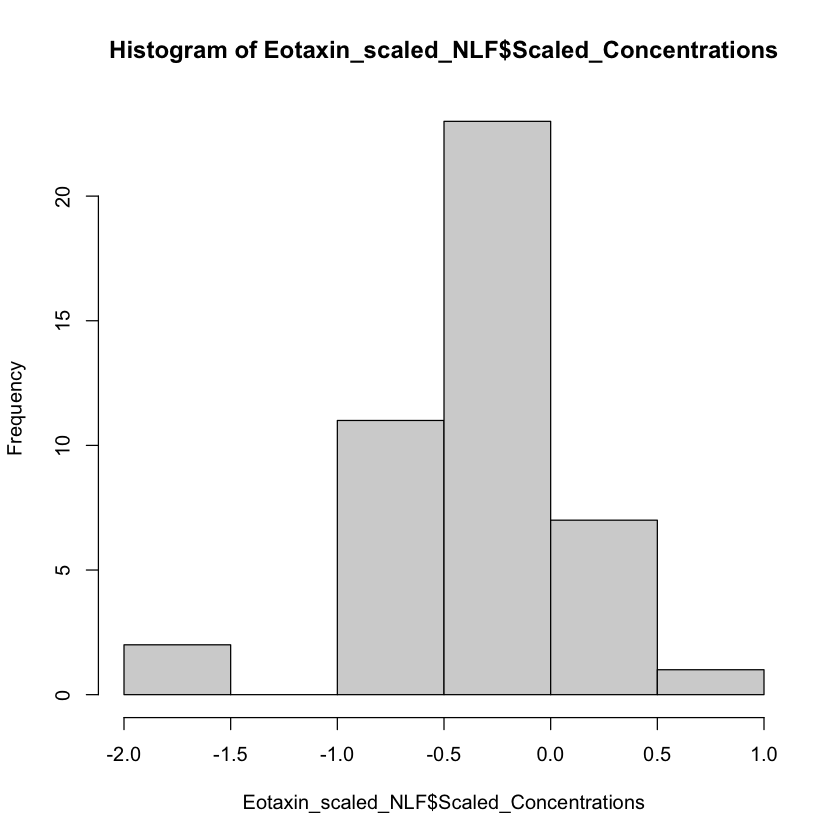

In [7]:
#checking for normal distribution
hist(Eotaxin_scaled_NLF$Scaled_Concentrations)

In [8]:
#formatting data to be put into the anova function 
change_data_types = function(scaled_df){
    #making compartment, smoking status, and covariates into factors
    scaled_df$Compartment = factor(scaled_df$Compartment, labels = c(unique(scaled_df$Compartment)))
    scaled_df$Group = factor(scaled_df$Group, labels = c(unique(scaled_df$Group)))
    scaled_df$Race = factor(scaled_df$Race, labels = c(unique(scaled_df$Race)))
    
    #making scaled_concentrations col into a numeric
    scaled_df$Scaled_Concentrations = as.numeric(scaled_df$Scaled_Concentrations)
    return(scaled_df)
}

#calling fn
#NLF
Eotaxin_scaled_factored_NLF = change_data_types(Eotaxin_scaled_NLF)
Eotaxin3_scaled_factored_NLF = change_data_types(Eotaxin3_scaled_NLF)
Fractalkine_scaled_factored_NLF = change_data_types(Fractalkine_scaled_NLF)
I309_scaled_factored_NLF = change_data_types(I309_scaled_NLF)
IFNg_scaled_factored_NLF = change_data_types(IFNg_scaled_NLF)
IL10_scaled_factored_NLF = change_data_types(IL10_scaled_NLF)
IL12p70_scaled_factored_NLF = change_data_types(IL12p70_scaled_NLF)
IL13_scaled_factored_NLF = change_data_types(IL13_scaled_NLF)
IL17B_scaled_factored_NLF = change_data_types(IL17B_scaled_NLF)
IL17D_scaled_factored_NLF = change_data_types(IL17D_scaled_NLF)
IL1b_scaled_factored_NLF = change_data_types(IL1b_scaled_NLF)
IL4_scaled_factored_NLF = change_data_types(IL4_scaled_NLF)
IL6_scaled_factored_NLF = change_data_types(IL6_scaled_NLF)
IL8_scaled_factored_NLF = change_data_types(IL8_scaled_NLF)
IP10_scaled_factored_NLF = change_data_types(IP10_scaled_NLF)
ITAC_scaled_factored_NLF = change_data_types(ITAC_scaled_NLF)
MCP1_scaled_factored_NLF = change_data_types(MCP1_scaled_NLF)
MIG_scaled_factored_NLF = change_data_types(MIG_scaled_NLF)
MIP1a_scaled_factored_NLF = change_data_types(MIP1a_scaled_NLF)
MIP1b_scaled_factored_NLF = change_data_types(MIP1b_scaled_NLF)
TARC_scaled_factored_NLF = change_data_types(TARC_scaled_NLF)
TNFa_scaled_factored_NLF = change_data_types(TNFa_scaled_NLF)

#ELF
Eotaxin_scaled_factored_ELF = change_data_types(Eotaxin_scaled_ELF)
Eotaxin3_scaled_factored_ELF = change_data_types(Eotaxin3_scaled_ELF)
Fractalkine_scaled_factored_ELF = change_data_types(Fractalkine_scaled_ELF)
I309_scaled_factored_ELF = change_data_types(I309_scaled_ELF)
IFNg_scaled_factored_ELF = change_data_types(IFNg_scaled_ELF)
IL10_scaled_factored_ELF = change_data_types(IL10_scaled_ELF)
IL12p70_scaled_factored_ELF = change_data_types(IL12p70_scaled_ELF)
IL13_scaled_factored_ELF = change_data_types(IL13_scaled_ELF)
IL17B_scaled_factored_ELF = change_data_types(IL17B_scaled_ELF)
IL17D_scaled_factored_ELF = change_data_types(IL17D_scaled_ELF)
IL1b_scaled_factored_ELF = change_data_types(IL1b_scaled_ELF)
IL4_scaled_factored_ELF = change_data_types(IL4_scaled_ELF)
IL6_scaled_factored_ELF = change_data_types(IL6_scaled_ELF)
IL8_scaled_factored_ELF = change_data_types(IL8_scaled_ELF)
IP10_scaled_factored_ELF = change_data_types(IP10_scaled_ELF)
ITAC_scaled_factored_ELF = change_data_types(ITAC_scaled_ELF)
MCP1_scaled_factored_ELF = change_data_types(MCP1_scaled_ELF)
MIG_scaled_factored_ELF = change_data_types(MIG_scaled_ELF)
MIP1a_scaled_factored_ELF = change_data_types(MIP1a_scaled_ELF)
MIP1b_scaled_factored_ELF = change_data_types(MIP1b_scaled_ELF)
TARC_scaled_factored_ELF = change_data_types(TARC_scaled_ELF)
TNFa_scaled_factored_ELF = change_data_types(TNFa_scaled_ELF)

#Sputum
Eotaxin_scaled_factored_Sputum = change_data_types(Eotaxin_scaled_Sputum)
Eotaxin3_scaled_factored_Sputum = change_data_types(Eotaxin3_scaled_Sputum)
Fractalkine_scaled_factored_Sputum = change_data_types(Fractalkine_scaled_Sputum)
I309_scaled_factored_Sputum = change_data_types(I309_scaled_Sputum)
IFNg_scaled_factored_Sputum = change_data_types(IFNg_scaled_Sputum)
IL10_scaled_factored_Sputum = change_data_types(IL10_scaled_Sputum)
IL12p70_scaled_factored_Sputum = change_data_types(IL12p70_scaled_Sputum)
IL13_scaled_factored_Sputum = change_data_types(IL13_scaled_Sputum)
IL17B_scaled_factored_Sputum = change_data_types(IL17B_scaled_Sputum)
IL17D_scaled_factored_Sputum = change_data_types(IL17D_scaled_Sputum)
IL1b_scaled_factored_Sputum = change_data_types(IL1b_scaled_Sputum)
IL4_scaled_factored_Sputum = change_data_types(IL4_scaled_Sputum)
IL6_scaled_factored_Sputum = change_data_types(IL6_scaled_Sputum)
IL8_scaled_factored_Sputum = change_data_types(IL8_scaled_Sputum)
IP10_scaled_factored_Sputum = change_data_types(IP10_scaled_Sputum)
ITAC_scaled_factored_Sputum = change_data_types(ITAC_scaled_Sputum)
MCP1_scaled_factored_Sputum = change_data_types(MCP1_scaled_Sputum)
MIG_scaled_factored_Sputum = change_data_types(MIG_scaled_Sputum)
MIP1a_scaled_factored_Sputum = change_data_types(MIP1a_scaled_Sputum)
MIP1b_scaled_factored_Sputum = change_data_types(MIP1b_scaled_Sputum)
TARC_scaled_factored_Sputum = change_data_types(TARC_scaled_Sputum)
TNFa_scaled_factored_Sputum = change_data_types(TNFa_scaled_Sputum)

#Serum
Eotaxin_scaled_factored_Serum = change_data_types(Eotaxin_scaled_Serum)
Eotaxin3_scaled_factored_Serum = change_data_types(Eotaxin3_scaled_Serum)
Fractalkine_scaled_factored_Serum = change_data_types(Fractalkine_scaled_Serum)
I309_scaled_factored_Serum = change_data_types(I309_scaled_Serum)
IFNg_scaled_factored_Serum = change_data_types(IFNg_scaled_Serum)
IL10_scaled_factored_Serum = change_data_types(IL10_scaled_Serum)
IL12p70_scaled_factored_Serum = change_data_types(IL12p70_scaled_Serum)
IL13_scaled_factored_Serum = change_data_types(IL13_scaled_Serum)
IL17B_scaled_factored_Serum = change_data_types(IL17B_scaled_Serum)
IL17D_scaled_factored_Serum = change_data_types(IL17D_scaled_Serum)
IL1b_scaled_factored_Serum = change_data_types(IL1b_scaled_Serum)
IL4_scaled_factored_Serum = change_data_types(IL4_scaled_Serum)
IL6_scaled_factored_Serum = change_data_types(IL6_scaled_Serum)
IL8_scaled_factored_Serum = change_data_types(IL8_scaled_Serum)
IP10_scaled_factored_Serum = change_data_types(IP10_scaled_Serum)
ITAC_scaled_factored_Serum = change_data_types(ITAC_scaled_Serum)
MCP1_scaled_factored_Serum = change_data_types(MCP1_scaled_Serum)
MIG_scaled_factored_Serum = change_data_types(MIG_scaled_Serum)
MIP1a_scaled_factored_Serum = change_data_types(MIP1a_scaled_Serum)
MIP1b_scaled_factored_Serum = change_data_types(MIP1b_scaled_Serum)
TARC_scaled_factored_Serum = change_data_types(TARC_scaled_Serum)
TNFa_scaled_factored_Serum = change_data_types(TNFa_scaled_Serum)

In [9]:
#contrasts show what compartments are being compared in anova
#these comparisons aren't what we want so I changed them in the function below
contrasts(Eotaxin_scaled_factored_NLF$Group)

,CS,NS
Ecig,0,0
CS,1,0
NS,0,1


                     Table of Contrasts
>                   NS    | CS  |  Ecig  |  Sum
>     Contrast 1 |  -1    |  1  |   0    |   0
>     Contrast 2 |  -1    |  0  |   1    |   0

> - Contrast 1: compares NS to CS
> - Contrast 2: compares NS to Ecig

In [10]:
get_anova = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is specified above
    anova = aov(Scaled_Concentrations~Group, data = scaled_df)
    return(anova)
}

#calling fn
#NLF
Eotaxin_anova_NLF = get_anova(Eotaxin_scaled_factored_NLF)
Eotaxin3_anova_NLF = get_anova(Eotaxin3_scaled_factored_NLF)
Fractalkine_anova_NLF = get_anova(Fractalkine_scaled_factored_NLF)
I309_anova_NLF = get_anova(I309_scaled_factored_NLF)
IFNg_anova_NLF = get_anova(IFNg_scaled_factored_NLF)
IL10_anova_NLF = get_anova(IL10_scaled_factored_NLF)
IL12p70_anova_NLF = get_anova(IL12p70_scaled_factored_NLF)
IL13_anova_NLF = get_anova(IL13_scaled_factored_NLF)
IL17B_anova_NLF = get_anova(IL17B_scaled_factored_NLF)
IL17D_anova_NLF = get_anova(IL17D_scaled_factored_NLF)
IL1b_anova_NLF = get_anova(IL1b_scaled_factored_NLF)
IL4_anova_NLF = get_anova(IL4_scaled_factored_NLF)
IL6_anova_NLF = get_anova(IL6_scaled_factored_NLF)
IL8_anova_NLF = get_anova(IL8_scaled_factored_NLF)
IP10_anova_NLF = get_anova(IP10_scaled_factored_NLF)
ITAC_anova_NLF = get_anova(ITAC_scaled_factored_NLF)
MCP1_anova_NLF = get_anova(MCP1_scaled_factored_NLF)
MIG_anova_NLF = get_anova(MIG_scaled_factored_NLF)
MIP1a_anova_NLF = get_anova(MIP1a_scaled_factored_NLF)
MIP1b_anova_NLF = get_anova(MIP1b_scaled_factored_NLF)
TARC_anova_NLF = get_anova(TARC_scaled_factored_NLF)
TNFa_anova_NLF = get_anova(TNFa_scaled_factored_NLF)

#ELF
Eotaxin_anova_ELF = get_anova(Eotaxin_scaled_factored_ELF)
Eotaxin3_anova_ELF = get_anova(Eotaxin3_scaled_factored_ELF)
Fractalkine_anova_ELF = get_anova(Fractalkine_scaled_factored_ELF)
I309_anova_ELF = get_anova(I309_scaled_factored_ELF)
IFNg_anova_ELF = get_anova(IFNg_scaled_factored_ELF)
IL10_anova_ELF = get_anova(IL10_scaled_factored_ELF)
IL12p70_anova_ELF = get_anova(IL12p70_scaled_factored_ELF)
IL13_anova_ELF = get_anova(IL13_scaled_factored_ELF)
IL17B_anova_ELF = get_anova(IL17B_scaled_factored_ELF)
IL17D_anova_ELF = get_anova(IL17D_scaled_factored_ELF)
IL1b_anova_ELF = get_anova(IL1b_scaled_factored_ELF)
IL4_anova_ELF = get_anova(IL4_scaled_factored_ELF)
IL6_anova_ELF = get_anova(IL6_scaled_factored_ELF)
IL8_anova_ELF = get_anova(IL8_scaled_factored_ELF)
IP10_anova_ELF = get_anova(IP10_scaled_factored_ELF)
ITAC_anova_ELF = get_anova(ITAC_scaled_factored_ELF)
MCP1_anova_ELF = get_anova(MCP1_scaled_factored_ELF)
MIG_anova_ELF = get_anova(MIG_scaled_factored_ELF)
MIP1a_anova_ELF = get_anova(MIP1a_scaled_factored_ELF)
MIP1b_anova_ELF = get_anova(MIP1b_scaled_factored_ELF)
TARC_anova_ELF = get_anova(TARC_scaled_factored_ELF)
TNFa_anova_ELF = get_anova(TNFa_scaled_factored_ELF)

#Sputum
Eotaxin_anova_Sputum = get_anova(Eotaxin_scaled_factored_Sputum)
Eotaxin3_anova_Sputum = get_anova(Eotaxin3_scaled_factored_Sputum)
Fractalkine_anova_Sputum = get_anova(Fractalkine_scaled_factored_Sputum)
I309_anova_Sputum = get_anova(I309_scaled_factored_Sputum)
IFNg_anova_Sputum = get_anova(IFNg_scaled_factored_Sputum)
IL10_anova_Sputum = get_anova(IL10_scaled_factored_Sputum)
IL12p70_anova_Sputum = get_anova(IL12p70_scaled_factored_Sputum)
IL13_anova_Sputum = get_anova(IL13_scaled_factored_Sputum)
IL17B_anova_Sputum = get_anova(IL17B_scaled_factored_Sputum)
IL17D_anova_Sputum = get_anova(IL17D_scaled_factored_Sputum)
IL1b_anova_Sputum = get_anova(IL1b_scaled_factored_Sputum)
IL4_anova_Sputum = get_anova(IL4_scaled_factored_Sputum)
IL6_anova_Sputum = get_anova(IL6_scaled_factored_Sputum)
IL8_anova_Sputum = get_anova(IL8_scaled_factored_Sputum)
IP10_anova_Sputum = get_anova(IP10_scaled_factored_Sputum)
ITAC_anova_Sputum = get_anova(ITAC_scaled_factored_Sputum)
MCP1_anova_Sputum = get_anova(MCP1_scaled_factored_Sputum)
MIG_anova_Sputum = get_anova(MIG_scaled_factored_Sputum)
MIP1a_anova_Sputum = get_anova(MIP1a_scaled_factored_Sputum)
MIP1b_anova_Sputum = get_anova(MIP1b_scaled_factored_Sputum)
TARC_anova_Sputum = get_anova(TARC_scaled_factored_Sputum)
TNFa_anova_Sputum = get_anova(TNFa_scaled_factored_Sputum)

#Serum
Eotaxin_anova_Serum = get_anova(Eotaxin_scaled_factored_Serum)
Eotaxin3_anova_Serum = get_anova(Eotaxin3_scaled_factored_Serum)
Fractalkine_anova_Serum = get_anova(Fractalkine_scaled_factored_Serum)
I309_anova_Serum = get_anova(I309_scaled_factored_Serum)
IFNg_anova_Serum = get_anova(IFNg_scaled_factored_Serum)
IL10_anova_Serum = get_anova(IL10_scaled_factored_Serum)
IL12p70_anova_Serum = get_anova(IL12p70_scaled_factored_Serum)
IL13_anova_Serum = get_anova(IL13_scaled_factored_Serum)
IL17B_anova_Serum = get_anova(IL17B_scaled_factored_Serum)
IL17D_anova_Serum = get_anova(IL17D_scaled_factored_Serum)
IL1b_anova_Serum = get_anova(IL1b_scaled_factored_Serum)
IL4_anova_Serum = get_anova(IL4_scaled_factored_Serum)
IL6_anova_Serum = get_anova(IL6_scaled_factored_Serum)
IL8_anova_Serum = get_anova(IL8_scaled_factored_Serum)
IP10_anova_Serum = get_anova(IP10_scaled_factored_Serum)
ITAC_anova_Serum = get_anova(ITAC_scaled_factored_Serum)
MCP1_anova_Serum = get_anova(MCP1_scaled_factored_Serum)
MIG_anova_Serum = get_anova(MIG_scaled_factored_Serum)
MIP1a_anova_Serum = get_anova(MIP1a_scaled_factored_Serum)
MIP1b_anova_Serum = get_anova(MIP1b_scaled_factored_Serum)
TARC_anova_Serum = get_anova(TARC_scaled_factored_Serum)
TNFa_anova_Serum = get_anova(TNFa_scaled_factored_Serum)

All of these yielded statistically significant results except IP10. ANOVA tests only tell us if there are differences between groups (cytokines), but not which ones hence we need a Tukey's test for post hoc to do that.

In [11]:
# Tukey's post hoc
#NLF
Eotaxin_tukey_anova_NLF = summary(glht(Eotaxin_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
Eotaxin3_tukey_anova_NLF = summary(glht(Eotaxin3_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
Fractalkine_tukey_anova_NLF = summary(glht(Fractalkine_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
I309_tukey_anova_NLF = summary(glht(I309_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IFNg_tukey_anova_NLF = summary(glht(IFNg_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL10_tukey_anova_NLF = summary(glht(IL10_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL12p70_tukey_anova_NLF = summary(glht(IL12p70_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL13_tukey_anova_NLF = summary(glht(IL13_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17B_tukey_anova_NLF = summary(glht(IL17B_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17D_tukey_anova_NLF = summary(glht(IL17D_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL1b_tukey_anova_NLF = summary(glht(IL1b_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL4_tukey_anova_NLF = summary(glht(IL4_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL6_tukey_anova_NLF = summary(glht(IL6_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL8_tukey_anova_NLF = summary(glht(IL8_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
IP10_tukey_anova_NLF = summary(glht(IP10_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
ITAC_tukey_anova_NLF = summary(glht(ITAC_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MCP1_tukey_anova_NLF = summary(glht(MCP1_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIG_tukey_anova_NLF = summary(glht(MIG_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1a_tukey_anova_NLF = summary(glht(MIP1a_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1b_tukey_anova_NLF = summary(glht(MIP1b_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TARC_tukey_anova_NLF = summary(glht(TARC_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TNFa_tukey_anova_NLF = summary(glht(TNFa_anova_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 

#ELF
Eotaxin_tukey_anova_ELF = summary(glht(Eotaxin_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
Eotaxin3_tukey_anova_ELF = summary(glht(Eotaxin3_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
Fractalkine_tukey_anova_ELF = summary(glht(Fractalkine_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
I309_tukey_anova_ELF = summary(glht(I309_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IFNg_tukey_anova_ELF = summary(glht(IFNg_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL10_tukey_anova_ELF = summary(glht(IL10_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL12p70_tukey_anova_ELF = summary(glht(IL12p70_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL13_tukey_anova_ELF = summary(glht(IL13_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17B_tukey_anova_ELF = summary(glht(IL17B_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17D_tukey_anova_ELF = summary(glht(IL17D_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL1b_tukey_anova_ELF = summary(glht(IL1b_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL4_tukey_anova_ELF = summary(glht(IL4_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL6_tukey_anova_ELF = summary(glht(IL6_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL8_tukey_anova_ELF = summary(glht(IL8_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
IP10_tukey_anova_ELF = summary(glht(IP10_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
ITAC_tukey_anova_ELF = summary(glht(ITAC_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MCP1_tukey_anova_ELF = summary(glht(MCP1_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIG_tukey_anova_ELF = summary(glht(MIG_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1a_tukey_anova_ELF = summary(glht(MIP1a_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1b_tukey_anova_ELF = summary(glht(MIP1b_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TARC_tukey_anova_ELF = summary(glht(TARC_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TNFa_tukey_anova_ELF = summary(glht(TNFa_anova_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 

#Sputum
Eotaxin_tukey_anova_Sputum = summary(glht(Eotaxin_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
Eotaxin3_tukey_anova_Sputum = summary(glht(Eotaxin3_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
Fractalkine_tukey_anova_Sputum = summary(glht(Fractalkine_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
I309_tukey_anova_Sputum = summary(glht(I309_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IFNg_tukey_anova_Sputum = summary(glht(IFNg_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL10_tukey_anova_Sputum = summary(glht(IL10_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL12p70_tukey_anova_Sputum = summary(glht(IL12p70_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL13_tukey_anova_Sputum = summary(glht(IL13_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17B_tukey_anova_Sputum = summary(glht(IL17B_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17D_tukey_anova_Sputum = summary(glht(IL17D_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL1b_tukey_anova_Sputum = summary(glht(IL1b_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL4_tukey_anova_Sputum = summary(glht(IL4_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL6_tukey_anova_Sputum = summary(glht(IL6_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL8_tukey_anova_Sputum = summary(glht(IL8_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
IP10_tukey_anova_Sputum = summary(glht(IP10_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
ITAC_tukey_anova_Sputum = summary(glht(ITAC_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MCP1_tukey_anova_Sputum = summary(glht(MCP1_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIG_tukey_anova_Sputum = summary(glht(MIG_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1a_tukey_anova_Sputum = summary(glht(MIP1a_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1b_tukey_anova_Sputum = summary(glht(MIP1b_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TARC_tukey_anova_Sputum = summary(glht(TARC_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TNFa_tukey_anova_Sputum = summary(glht(TNFa_anova_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 

#Serum
Eotaxin_tukey_anova_Serum = summary(glht(Eotaxin_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
Eotaxin3_tukey_anova_Serum = summary(glht(Eotaxin3_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
Fractalkine_tukey_anova_Serum = summary(glht(Fractalkine_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
I309_tukey_anova_Serum = summary(glht(I309_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IFNg_tukey_anova_Serum = summary(glht(IFNg_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL10_tukey_anova_Serum = summary(glht(IL10_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL12p70_tukey_anova_Serum = summary(glht(IL12p70_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL13_tukey_anova_Serum = summary(glht(IL13_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17B_tukey_anova_Serum = summary(glht(IL17B_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17D_tukey_anova_Serum = summary(glht(IL17D_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL1b_tukey_anova_Serum = summary(glht(IL1b_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL4_tukey_anova_Serum = summary(glht(IL4_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL6_tukey_anova_Serum = summary(glht(IL6_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL8_tukey_anova_Serum = summary(glht(IL8_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
IP10_tukey_anova_Serum = summary(glht(IP10_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
ITAC_tukey_anova_Serum = summary(glht(ITAC_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MCP1_tukey_anova_Serum = summary(glht(MCP1_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIG_tukey_anova_Serum = summary(glht(MIG_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1a_tukey_anova_Serum = summary(glht(MIP1a_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1b_tukey_anova_Serum = summary(glht(MIP1b_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TARC_tukey_anova_Serum = summary(glht(TARC_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TNFa_tukey_anova_Serum = summary(glht(TNFa_anova_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 

Warning message in summary.lm(object, ...):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(model):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(object, ...):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(model):
“essentially perfect fit: summary may be unreliable”


# ANCOVA

In [12]:
#controlling for age
get_ancova_age = function(scaled_df){
    contrasts(scaled_df$Group) = cbind(c(-1,1,0),c(-1,0,1)) #meaning is explained above
    ancova = aov(Scaled_Concentrations~Age+Group, data = scaled_df) #the covariate must go first!!
    return(ancova)
}

#calling fn
#NLF
Eotaxin_ancova_age_NLF = get_ancova_age(Eotaxin_scaled_factored_NLF)
Eotaxin3_ancova_age_NLF = get_ancova_age(Eotaxin3_scaled_factored_NLF)
Fractalkine_ancova_age_NLF = get_ancova_age(Fractalkine_scaled_factored_NLF)
I309_ancova_age_NLF = get_ancova_age(I309_scaled_factored_NLF)
IFNg_ancova_age_NLF = get_ancova_age(IFNg_scaled_factored_NLF)
IL10_ancova_age_NLF = get_ancova_age(IL10_scaled_factored_NLF)
IL12p70_ancova_age_NLF = get_ancova_age(IL12p70_scaled_factored_NLF)
IL13_ancova_age_NLF = get_ancova_age(IL13_scaled_factored_NLF)
IL17B_ancova_age_NLF = get_ancova_age(IL17B_scaled_factored_NLF)
IL17D_ancova_age_NLF = get_ancova_age(IL17D_scaled_factored_NLF)
IL1b_ancova_age_NLF = get_ancova_age(IL1b_scaled_factored_NLF)
IL4_ancova_age_NLF = get_ancova_age(IL4_scaled_factored_NLF)
IL6_ancova_age_NLF = get_ancova_age(IL6_scaled_factored_NLF)
IL8_ancova_age_NLF = get_ancova_age(IL8_scaled_factored_NLF)
IP10_ancova_age_NLF = get_ancova_age(IP10_scaled_factored_NLF)
ITAC_ancova_age_NLF = get_ancova_age(ITAC_scaled_factored_NLF)
MCP1_ancova_age_NLF = get_ancova_age(MCP1_scaled_factored_NLF)
MIG_ancova_age_NLF = get_ancova_age(MIG_scaled_factored_NLF)
MIP1a_ancova_age_NLF = get_ancova_age(MIP1a_scaled_factored_NLF)
MIP1b_ancova_age_NLF = get_ancova_age(MIP1b_scaled_factored_NLF)
TARC_ancova_age_NLF = get_ancova_age(TARC_scaled_factored_NLF)
TNFa_ancova_age_NLF = get_ancova_age(TNFa_scaled_factored_NLF)

#ELF
Eotaxin_ancova_age_ELF = get_ancova_age(Eotaxin_scaled_factored_ELF)
Eotaxin3_ancova_age_ELF = get_ancova_age(Eotaxin3_scaled_factored_ELF)
Fractalkine_ancova_age_ELF = get_ancova_age(Fractalkine_scaled_factored_ELF)
I309_ancova_age_ELF = get_ancova_age(I309_scaled_factored_ELF)
IFNg_ancova_age_ELF = get_ancova_age(IFNg_scaled_factored_ELF)
IL10_ancova_age_ELF = get_ancova_age(IL10_scaled_factored_ELF)
IL12p70_ancova_age_ELF = get_ancova_age(IL12p70_scaled_factored_ELF)
IL13_ancova_age_ELF = get_ancova_age(IL13_scaled_factored_ELF)
IL17B_ancova_age_ELF = get_ancova_age(IL17B_scaled_factored_ELF)
IL17D_ancova_age_ELF = get_ancova_age(IL17D_scaled_factored_ELF)
IL1b_ancova_age_ELF = get_ancova_age(IL1b_scaled_factored_ELF)
IL4_ancova_age_ELF = get_ancova_age(IL4_scaled_factored_ELF)
IL6_ancova_age_ELF = get_ancova_age(IL6_scaled_factored_ELF)
IL8_ancova_age_ELF = get_ancova_age(IL8_scaled_factored_ELF)
IP10_ancova_age_ELF = get_ancova_age(IP10_scaled_factored_ELF)
ITAC_ancova_age_ELF = get_ancova_age(ITAC_scaled_factored_ELF)
MCP1_ancova_age_ELF = get_ancova_age(MCP1_scaled_factored_ELF)
MIG_ancova_age_ELF = get_ancova_age(MIG_scaled_factored_ELF)
MIP1a_ancova_age_ELF = get_ancova_age(MIP1a_scaled_factored_ELF)
MIP1b_ancova_age_ELF = get_ancova_age(MIP1b_scaled_factored_ELF)
TARC_ancova_age_ELF = get_ancova_age(TARC_scaled_factored_ELF)
TNFa_ancova_age_ELF = get_ancova_age(TNFa_scaled_factored_ELF)

#Sputum
Eotaxin_ancova_age_Sputum = get_ancova_age(Eotaxin_scaled_factored_Sputum)
Eotaxin3_ancova_age_Sputum = get_ancova_age(Eotaxin3_scaled_factored_Sputum)
Fractalkine_ancova_age_Sputum = get_ancova_age(Fractalkine_scaled_factored_Sputum)
I309_ancova_age_Sputum = get_ancova_age(I309_scaled_factored_Sputum)
IFNg_ancova_age_Sputum = get_ancova_age(IFNg_scaled_factored_Sputum)
IL10_ancova_age_Sputum = get_ancova_age(IL10_scaled_factored_Sputum)
IL12p70_ancova_age_Sputum = get_ancova_age(IL12p70_scaled_factored_Sputum)
IL13_ancova_age_Sputum = get_ancova_age(IL13_scaled_factored_Sputum)
IL17B_ancova_age_Sputum = get_ancova_age(IL17B_scaled_factored_Sputum)
IL17D_ancova_age_Sputum = get_ancova_age(IL17D_scaled_factored_Sputum)
IL1b_ancova_age_Sputum = get_ancova_age(IL1b_scaled_factored_Sputum)
IL4_ancova_age_Sputum = get_ancova_age(IL4_scaled_factored_Sputum)
IL6_ancova_age_Sputum = get_ancova_age(IL6_scaled_factored_Sputum)
IL8_ancova_age_Sputum = get_ancova_age(IL8_scaled_factored_Sputum)
IP10_ancova_age_Sputum = get_ancova_age(IP10_scaled_factored_Sputum)
ITAC_ancova_age_Sputum = get_ancova_age(ITAC_scaled_factored_Sputum)
MCP1_ancova_age_Sputum = get_ancova_age(MCP1_scaled_factored_Sputum)
MIG_ancova_age_Sputum = get_ancova_age(MIG_scaled_factored_Sputum)
MIP1a_ancova_age_Sputum = get_ancova_age(MIP1a_scaled_factored_Sputum)
MIP1b_ancova_age_Sputum = get_ancova_age(MIP1b_scaled_factored_Sputum)
TARC_ancova_age_Sputum = get_ancova_age(TARC_scaled_factored_Sputum)
TNFa_ancova_age_Sputum = get_ancova_age(TNFa_scaled_factored_Sputum)

#Serum
Eotaxin_ancova_age_Serum = get_ancova_age(Eotaxin_scaled_factored_Serum)
Eotaxin3_ancova_age_Serum = get_ancova_age(Eotaxin3_scaled_factored_Serum)
Fractalkine_ancova_age_Serum = get_ancova_age(Fractalkine_scaled_factored_Serum)
I309_ancova_age_Serum = get_ancova_age(I309_scaled_factored_Serum)
IFNg_ancova_age_Serum = get_ancova_age(IFNg_scaled_factored_Serum)
IL10_ancova_age_Serum = get_ancova_age(IL10_scaled_factored_Serum)
IL12p70_ancova_age_Serum = get_ancova_age(IL12p70_scaled_factored_Serum)
IL13_ancova_age_Serum = get_ancova_age(IL13_scaled_factored_Serum)
IL17B_ancova_age_Serum = get_ancova_age(IL17B_scaled_factored_Serum)
IL17D_ancova_age_Serum = get_ancova_age(IL17D_scaled_factored_Serum)
IL1b_ancova_age_Serum = get_ancova_age(IL1b_scaled_factored_Serum)
IL4_ancova_age_Serum = get_ancova_age(IL4_scaled_factored_Serum)
IL6_ancova_age_Serum = get_ancova_age(IL6_scaled_factored_Serum)
IL8_ancova_age_Serum = get_ancova_age(IL8_scaled_factored_Serum)
IP10_ancova_age_Serum = get_ancova_age(IP10_scaled_factored_Serum)
ITAC_ancova_age_Serum = get_ancova_age(ITAC_scaled_factored_Serum)
MCP1_ancova_age_Serum = get_ancova_age(MCP1_scaled_factored_Serum)
MIG_ancova_age_Serum = get_ancova_age(MIG_scaled_factored_Serum)
MIP1a_ancova_age_Serum = get_ancova_age(MIP1a_scaled_factored_Serum)
MIP1b_ancova_age_Serum = get_ancova_age(MIP1b_scaled_factored_Serum)
TARC_ancova_age_Serum = get_ancova_age(TARC_scaled_factored_Serum)
TNFa_ancova_age_Serum = get_ancova_age(TNFa_scaled_factored_Serum)

In [13]:
#Tukey's post hoc
#NLF
Eotaxin_tukey_ancova_age_NLF = summary(glht(Eotaxin_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
Eotaxin3_tukey_ancova_age_NLF = summary(glht(Eotaxin3_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
Fractalkine_tukey_ancova_age_NLF = summary(glht(Fractalkine_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
I309_tukey_ancova_age_NLF = summary(glht(I309_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IFNg_tukey_ancova_age_NLF = summary(glht(IFNg_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL10_tukey_ancova_age_NLF = summary(glht(IL10_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL12p70_tukey_ancova_age_NLF = summary(glht(IL12p70_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL13_tukey_ancova_age_NLF = summary(glht(IL13_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17B_tukey_ancova_age_NLF = summary(glht(IL17B_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17D_tukey_ancova_age_NLF = summary(glht(IL17D_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL1b_tukey_ancova_age_NLF = summary(glht(IL1b_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL4_tukey_ancova_age_NLF = summary(glht(IL4_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL6_tukey_ancova_age_NLF = summary(glht(IL6_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL8_tukey_ancova_age_NLF = summary(glht(IL8_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
IP10_tukey_ancova_age_NLF = summary(glht(IP10_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
ITAC_tukey_ancova_age_NLF = summary(glht(ITAC_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MCP1_tukey_ancova_age_NLF = summary(glht(MCP1_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIG_tukey_ancova_age_NLF = summary(glht(MIG_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1a_tukey_ancova_age_NLF = summary(glht(MIP1a_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1b_tukey_ancova_age_NLF = summary(glht(MIP1b_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TARC_tukey_ancova_age_NLF = summary(glht(TARC_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TNFa_tukey_ancova_age_NLF = summary(glht(TNFa_ancova_age_NLF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 

#ELF
Eotaxin_tukey_ancova_age_ELF = summary(glht(Eotaxin_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
Eotaxin3_tukey_ancova_age_ELF = summary(glht(Eotaxin3_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
Fractalkine_tukey_ancova_age_ELF = summary(glht(Fractalkine_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
I309_tukey_ancova_age_ELF = summary(glht(I309_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IFNg_tukey_ancova_age_ELF = summary(glht(IFNg_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL10_tukey_ancova_age_ELF = summary(glht(IL10_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL12p70_tukey_ancova_age_ELF = summary(glht(IL12p70_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL13_tukey_ancova_age_ELF = summary(glht(IL13_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17B_tukey_ancova_age_ELF = summary(glht(IL17B_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17D_tukey_ancova_age_ELF = summary(glht(IL17D_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL1b_tukey_ancova_age_ELF = summary(glht(IL1b_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL4_tukey_ancova_age_ELF = summary(glht(IL4_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL6_tukey_ancova_age_ELF = summary(glht(IL6_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL8_tukey_ancova_age_ELF = summary(glht(IL8_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
IP10_tukey_ancova_age_ELF = summary(glht(IP10_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
ITAC_tukey_ancova_age_ELF = summary(glht(ITAC_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MCP1_tukey_ancova_age_ELF = summary(glht(MCP1_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIG_tukey_ancova_age_ELF = summary(glht(MIG_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1a_tukey_ancova_age_ELF = summary(glht(MIP1a_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1b_tukey_ancova_age_ELF = summary(glht(MIP1b_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TARC_tukey_ancova_age_ELF = summary(glht(TARC_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TNFa_tukey_ancova_age_ELF = summary(glht(TNFa_ancova_age_ELF, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 

#Sputum
Eotaxin_tukey_ancova_age_Sputum = summary(glht(Eotaxin_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
Eotaxin3_tukey_ancova_age_Sputum = summary(glht(Eotaxin3_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
Fractalkine_tukey_ancova_age_Sputum = summary(glht(Fractalkine_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
I309_tukey_ancova_age_Sputum = summary(glht(I309_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IFNg_tukey_ancova_age_Sputum = summary(glht(IFNg_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL10_tukey_ancova_age_Sputum = summary(glht(IL10_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL12p70_tukey_ancova_age_Sputum = summary(glht(IL12p70_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL13_tukey_ancova_age_Sputum = summary(glht(IL13_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17B_tukey_ancova_age_Sputum = summary(glht(IL17B_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17D_tukey_ancova_age_Sputum = summary(glht(IL17D_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL1b_tukey_ancova_age_Sputum = summary(glht(IL1b_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL4_tukey_ancova_age_Sputum = summary(glht(IL4_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL6_tukey_ancova_age_Sputum = summary(glht(IL6_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL8_tukey_ancova_age_Sputum = summary(glht(IL8_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
IP10_tukey_ancova_age_Sputum = summary(glht(IP10_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
ITAC_tukey_ancova_age_Sputum = summary(glht(ITAC_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MCP1_tukey_ancova_age_Sputum = summary(glht(MCP1_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIG_tukey_ancova_age_Sputum = summary(glht(MIG_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1a_tukey_ancova_age_Sputum = summary(glht(MIP1a_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1b_tukey_ancova_age_Sputum = summary(glht(MIP1b_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TARC_tukey_ancova_age_Sputum = summary(glht(TARC_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TNFa_tukey_ancova_age_Sputum = summary(glht(TNFa_ancova_age_Sputum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 

#Serum
Eotaxin_tukey_ancova_age_Serum = summary(glht(Eotaxin_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
Eotaxin3_tukey_ancova_age_Serum = summary(glht(Eotaxin3_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
Fractalkine_tukey_ancova_age_Serum = summary(glht(Fractalkine_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
I309_tukey_ancova_age_Serum = summary(glht(I309_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IFNg_tukey_ancova_age_Serum = summary(glht(IFNg_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL10_tukey_ancova_age_Serum = summary(glht(IL10_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL12p70_tukey_ancova_age_Serum = summary(glht(IL12p70_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL13_tukey_ancova_age_Serum = summary(glht(IL13_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17B_tukey_ancova_age_Serum = summary(glht(IL17B_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL17D_tukey_ancova_age_Serum = summary(glht(IL17D_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL1b_tukey_ancova_age_Serum = summary(glht(IL1b_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL4_tukey_ancova_age_Serum = summary(glht(IL4_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL6_tukey_ancova_age_Serum = summary(glht(IL6_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
IL8_tukey_ancova_age_Serum = summary(glht(IL8_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none"))
IP10_tukey_ancova_age_Serum = summary(glht(IP10_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
ITAC_tukey_ancova_age_Serum = summary(glht(ITAC_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MCP1_tukey_ancova_age_Serum = summary(glht(MCP1_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIG_tukey_ancova_age_Serum = summary(glht(MIG_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1a_tukey_ancova_age_Serum = summary(glht(MIP1a_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
MIP1b_tukey_ancova_age_Serum = summary(glht(MIP1b_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TARC_tukey_ancova_age_Serum = summary(glht(TARC_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 
TNFa_tukey_ancova_age_Serum = summary(glht(TNFa_ancova_age_Serum, linfct = mcp(Group = "Tukey")), test = adjusted("none")) 

Warning message in summary.lm(object, ...):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(model):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(object, ...):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(model):
“essentially perfect fit: summary may be unreliable”


# ANOVA/ANCOVA Tables

In [14]:
extract_values = function(anova_results){
  #extracting f and p values from the anova to be put into a table
  cytokine_summary = summary(anova_results)[[1]][1, 2:5] #f value, pvalue
  f_value = cytokine_summary$`F value`
  p_value = cytokine_summary$`Pr(>F)`
  
  cytokine_anova_values = c(f_value,p_value)
  return(cytokine_anova_values)
}

#anova
#NLF
Eotaxin_anova_values_NLF = extract_values(Eotaxin_anova_NLF)
Eotaxin3_anova_values_NLF = extract_values(Eotaxin3_anova_NLF)
Fractalkine_anova_values_NLF = extract_values(Fractalkine_anova_NLF)
I309_anova_values_NLF = extract_values(I309_anova_NLF)
IFNg_anova_values_NLF = extract_values(IFNg_anova_NLF)
IL10_anova_values_NLF = extract_values(IL10_anova_NLF)
IL12p70_anova_values_NLF = extract_values(IL12p70_anova_NLF)
IL13_anova_values_NLF = extract_values(IL13_anova_NLF)
IL17B_anova_values_NLF = extract_values(IL17B_anova_NLF)
IL17D_anova_values_NLF = extract_values(IL17D_anova_NLF)
IL1b_anova_values_NLF = extract_values(IL1b_anova_NLF)
IL4_anova_values_NLF = extract_values(IL4_anova_NLF)
IL6_anova_values_NLF = extract_values(IL6_anova_NLF)
IL8_anova_values_NLF = extract_values(IL8_anova_NLF)
IP10_anova_values_NLF = extract_values(IP10_anova_NLF)
ITAC_anova_values_NLF = extract_values(ITAC_anova_NLF)
MCP1_anova_values_NLF = extract_values(MCP1_anova_NLF)
MIG_anova_values_NLF = extract_values(MIG_anova_NLF)
MIP1a_anova_values_NLF = extract_values(MIP1a_anova_NLF)
MIP1b_anova_values_NLF = extract_values(MIP1b_anova_NLF)
TARC_anova_values_NLF = extract_values(TARC_anova_NLF)
TNFa_anova_values_NLF = extract_values(TNFa_anova_NLF)

#ELF
Eotaxin_anova_values_ELF = extract_values(Eotaxin_anova_ELF)
Eotaxin3_anova_values_ELF = extract_values(Eotaxin3_anova_ELF)
Fractalkine_anova_values_ELF = extract_values(Fractalkine_anova_ELF)
I309_anova_values_ELF = extract_values(I309_anova_ELF)
IFNg_anova_values_ELF = extract_values(IFNg_anova_ELF)
IL10_anova_values_ELF = extract_values(IL10_anova_ELF)
IL12p70_anova_values_ELF = extract_values(IL12p70_anova_ELF)
IL13_anova_values_ELF = extract_values(IL13_anova_ELF)
IL17B_anova_values_ELF = extract_values(IL17B_anova_ELF)
IL17D_anova_values_ELF = extract_values(IL17D_anova_ELF)
IL1b_anova_values_ELF = extract_values(IL1b_anova_ELF)
IL4_anova_values_ELF = extract_values(IL4_anova_ELF)
IL6_anova_values_ELF = extract_values(IL6_anova_ELF)
IL8_anova_values_ELF = extract_values(IL8_anova_ELF)
IP10_anova_values_ELF = extract_values(IP10_anova_ELF)
ITAC_anova_values_ELF = extract_values(ITAC_anova_ELF)
MCP1_anova_values_ELF = extract_values(MCP1_anova_ELF)
MIG_anova_values_ELF = extract_values(MIG_anova_ELF)
MIP1a_anova_values_ELF = extract_values(MIP1a_anova_ELF)
MIP1b_anova_values_ELF = extract_values(MIP1b_anova_ELF)
TARC_anova_values_ELF = extract_values(TARC_anova_ELF)
TNFa_anova_values_ELF = extract_values(TNFa_anova_ELF)

#Sputum
Eotaxin_anova_values_Sputum = extract_values(Eotaxin_anova_Sputum)
Eotaxin3_anova_values_Sputum = extract_values(Eotaxin3_anova_Sputum)
Fractalkine_anova_values_Sputum = extract_values(Fractalkine_anova_Sputum)
I309_anova_values_Sputum = extract_values(I309_anova_Sputum)
IFNg_anova_values_Sputum = extract_values(IFNg_anova_Sputum)
IL10_anova_values_Sputum = extract_values(IL10_anova_Sputum)
IL12p70_anova_values_Sputum = extract_values(IL12p70_anova_Sputum)
IL13_anova_values_Sputum = extract_values(IL13_anova_Sputum)
IL17B_anova_values_Sputum = extract_values(IL17B_anova_Sputum)
IL17D_anova_values_Sputum = extract_values(IL17D_anova_Sputum)
IL1b_anova_values_Sputum = extract_values(IL1b_anova_Sputum)
IL4_anova_values_Sputum = extract_values(IL4_anova_Sputum)
IL6_anova_values_Sputum = extract_values(IL6_anova_Sputum)
IL8_anova_values_Sputum = extract_values(IL8_anova_Sputum)
IP10_anova_values_Sputum = extract_values(IP10_anova_Sputum)
ITAC_anova_values_Sputum = extract_values(ITAC_anova_Sputum)
MCP1_anova_values_Sputum = extract_values(MCP1_anova_Sputum)
MIG_anova_values_Sputum = extract_values(MIG_anova_Sputum)
MIP1a_anova_values_Sputum = extract_values(MIP1a_anova_Sputum)
MIP1b_anova_values_Sputum = extract_values(MIP1b_anova_Sputum)
TARC_anova_values_Sputum = extract_values(TARC_anova_Sputum)
TNFa_anova_values_Sputum = extract_values(TNFa_anova_Sputum)

#Serum
Eotaxin_anova_values_Serum = extract_values(Eotaxin_anova_Serum)
Eotaxin3_anova_values_Serum = extract_values(Eotaxin3_anova_Serum)
Fractalkine_anova_values_Serum = extract_values(Fractalkine_anova_Serum)
I309_anova_values_Serum = extract_values(I309_anova_Serum)
IFNg_anova_values_Serum = extract_values(IFNg_anova_Serum)
IL10_anova_values_Serum = extract_values(IL10_anova_Serum)
IL12p70_anova_values_Serum = extract_values(IL12p70_anova_Serum)
IL13_anova_values_Serum = extract_values(IL13_anova_Serum)
IL17B_anova_values_Serum = extract_values(IL17B_anova_Serum)
IL17D_anova_values_Serum = extract_values(IL17D_anova_Serum)
IL1b_anova_values_Serum = extract_values(IL1b_anova_Serum)
IL4_anova_values_Serum = extract_values(IL4_anova_Serum)
IL6_anova_values_Serum = extract_values(IL6_anova_Serum)
IL8_anova_values_Serum = extract_values(IL8_anova_Serum)
IP10_anova_values_Serum = extract_values(IP10_anova_Serum)
ITAC_anova_values_Serum = extract_values(ITAC_anova_Serum)
MCP1_anova_values_Serum = extract_values(MCP1_anova_Serum)
MIG_anova_values_Serum = extract_values(MIG_anova_Serum)
MIP1a_anova_values_Serum = extract_values(MIP1a_anova_Serum)
MIP1b_anova_values_Serum = extract_values(MIP1b_anova_Serum)
TARC_anova_values_Serum = extract_values(TARC_anova_Serum)
TNFa_anova_values_Serum = extract_values(TNFa_anova_Serum)

#ancova age
#NLF
Eotaxin_ancova_age_values_NLF = extract_values(Eotaxin_ancova_age_NLF)
Eotaxin3_ancova_age_values_NLF = extract_values(Eotaxin3_ancova_age_NLF)
Fractalkine_ancova_age_values_NLF = extract_values(Fractalkine_ancova_age_NLF)
I309_ancova_age_values_NLF = extract_values(I309_ancova_age_NLF)
IFNg_ancova_age_values_NLF = extract_values(IFNg_ancova_age_NLF)
IL10_ancova_age_values_NLF = extract_values(IL10_ancova_age_NLF)
IL12p70_ancova_age_values_NLF = extract_values(IL12p70_ancova_age_NLF)
IL13_ancova_age_values_NLF = extract_values(IL13_ancova_age_NLF)
IL17B_ancova_age_values_NLF = extract_values(IL17B_ancova_age_NLF)
IL17D_ancova_age_values_NLF = extract_values(IL17D_ancova_age_NLF)
IL1b_ancova_age_values_NLF = extract_values(IL1b_ancova_age_NLF)
IL4_ancova_age_values_NLF = extract_values(IL4_ancova_age_NLF)
IL6_ancova_age_values_NLF = extract_values(IL6_ancova_age_NLF)
IL8_ancova_age_values_NLF = extract_values(IL8_ancova_age_NLF)
IP10_ancova_age_values_NLF = extract_values(IP10_ancova_age_NLF)
ITAC_ancova_age_values_NLF = extract_values(ITAC_ancova_age_NLF)
MCP1_ancova_age_values_NLF = extract_values(MCP1_ancova_age_NLF)
MIG_ancova_age_values_NLF = extract_values(MIG_ancova_age_NLF)
MIP1a_ancova_age_values_NLF = extract_values(MIP1a_ancova_age_NLF)
MIP1b_ancova_age_values_NLF = extract_values(MIP1b_ancova_age_NLF)
TARC_ancova_age_values_NLF = extract_values(TARC_ancova_age_NLF)
TNFa_ancova_age_values_NLF = extract_values(TNFa_ancova_age_NLF)

#ELF
Eotaxin_ancova_age_values_ELF = extract_values(Eotaxin_ancova_age_ELF)
Eotaxin3_ancova_age_values_ELF = extract_values(Eotaxin3_ancova_age_ELF)
Fractalkine_ancova_age_values_ELF = extract_values(Fractalkine_ancova_age_ELF)
I309_ancova_age_values_ELF = extract_values(I309_ancova_age_ELF)
IFNg_ancova_age_values_ELF = extract_values(IFNg_ancova_age_ELF)
IL10_ancova_age_values_ELF = extract_values(IL10_ancova_age_ELF)
IL12p70_ancova_age_values_ELF = extract_values(IL12p70_ancova_age_ELF)
IL13_ancova_age_values_ELF = extract_values(IL13_ancova_age_ELF)
IL17B_ancova_age_values_ELF = extract_values(IL17B_ancova_age_ELF)
IL17D_ancova_age_values_ELF = extract_values(IL17D_ancova_age_ELF)
IL1b_ancova_age_values_ELF = extract_values(IL1b_ancova_age_ELF)
IL4_ancova_age_values_ELF = extract_values(IL4_ancova_age_ELF)
IL6_ancova_age_values_ELF = extract_values(IL6_ancova_age_ELF)
IL8_ancova_age_values_ELF = extract_values(IL8_ancova_age_ELF)
IP10_ancova_age_values_ELF = extract_values(IP10_ancova_age_ELF)
ITAC_ancova_age_values_ELF = extract_values(ITAC_ancova_age_ELF)
MCP1_ancova_age_values_ELF = extract_values(MCP1_ancova_age_ELF)
MIG_ancova_age_values_ELF = extract_values(MIG_ancova_age_ELF)
MIP1a_ancova_age_values_ELF = extract_values(MIP1a_ancova_age_ELF)
MIP1b_ancova_age_values_ELF = extract_values(MIP1b_ancova_age_ELF)
TARC_ancova_age_values_ELF = extract_values(TARC_ancova_age_ELF)
TNFa_ancova_age_values_ELF = extract_values(TNFa_ancova_age_ELF)

#Sputum
Eotaxin_ancova_age_values_Sputum = extract_values(Eotaxin_ancova_age_Sputum)
Eotaxin3_ancova_age_values_Sputum = extract_values(Eotaxin3_ancova_age_Sputum)
Fractalkine_ancova_age_values_Sputum = extract_values(Fractalkine_ancova_age_Sputum)
I309_ancova_age_values_Sputum = extract_values(I309_ancova_age_Sputum)
IFNg_ancova_age_values_Sputum = extract_values(IFNg_ancova_age_Sputum)
IL10_ancova_age_values_Sputum = extract_values(IL10_ancova_age_Sputum)
IL12p70_ancova_age_values_Sputum = extract_values(IL12p70_ancova_age_Sputum)
IL13_ancova_age_values_Sputum = extract_values(IL13_ancova_age_Sputum)
IL17B_ancova_age_values_Sputum = extract_values(IL17B_ancova_age_Sputum)
IL17D_ancova_age_values_Sputum = extract_values(IL17D_ancova_age_Sputum)
IL1b_ancova_age_values_Sputum = extract_values(IL1b_ancova_age_Sputum)
IL4_ancova_age_values_Sputum = extract_values(IL4_ancova_age_Sputum)
IL6_ancova_age_values_Sputum = extract_values(IL6_ancova_age_Sputum)
IL8_ancova_age_values_Sputum = extract_values(IL8_ancova_age_Sputum)
IP10_ancova_age_values_Sputum = extract_values(IP10_ancova_age_Sputum)
ITAC_ancova_age_values_Sputum = extract_values(ITAC_ancova_age_Sputum)
MCP1_ancova_age_values_Sputum = extract_values(MCP1_ancova_age_Sputum)
MIG_ancova_age_values_Sputum = extract_values(MIG_ancova_age_Sputum)
MIP1a_ancova_age_values_Sputum = extract_values(MIP1a_ancova_age_Sputum)
MIP1b_ancova_age_values_Sputum = extract_values(MIP1b_ancova_age_Sputum)
TARC_ancova_age_values_Sputum = extract_values(TARC_ancova_age_Sputum)
TNFa_ancova_age_values_Sputum = extract_values(TNFa_ancova_age_Sputum)

#Serum
Eotaxin_ancova_age_values_Serum = extract_values(Eotaxin_ancova_age_Serum)
Eotaxin3_ancova_age_values_Serum = extract_values(Eotaxin3_ancova_age_Serum)
Fractalkine_ancova_age_values_Serum = extract_values(Fractalkine_ancova_age_Serum)
I309_ancova_age_values_Serum = extract_values(I309_ancova_age_Serum)
IFNg_ancova_age_values_Serum = extract_values(IFNg_ancova_age_Serum)
IL10_ancova_age_values_Serum = extract_values(IL10_ancova_age_Serum)
IL12p70_ancova_age_values_Serum = extract_values(IL12p70_ancova_age_Serum)
IL13_ancova_age_values_Serum = extract_values(IL13_ancova_age_Serum)
IL17B_ancova_age_values_Serum = extract_values(IL17B_ancova_age_Serum)
IL17D_ancova_age_values_Serum = extract_values(IL17D_ancova_age_Serum)
IL1b_ancova_age_values_Serum = extract_values(IL1b_ancova_age_Serum)
IL4_ancova_age_values_Serum = extract_values(IL4_ancova_age_Serum)
IL6_ancova_age_values_Serum = extract_values(IL6_ancova_age_Serum)
IL8_ancova_age_values_Serum = extract_values(IL8_ancova_age_Serum)
IP10_ancova_age_values_Serum = extract_values(IP10_ancova_age_Serum)
ITAC_ancova_age_values_Serum = extract_values(ITAC_ancova_age_Serum)
MCP1_ancova_age_values_Serum = extract_values(MCP1_ancova_age_Serum)
MIG_ancova_age_values_Serum = extract_values(MIG_ancova_age_Serum)
MIP1a_ancova_age_values_Serum = extract_values(MIP1a_ancova_age_Serum)
MIP1b_ancova_age_values_Serum = extract_values(MIP1b_ancova_age_Serum)
TARC_ancova_age_values_Serum = extract_values(TARC_ancova_age_Serum)
TNFa_ancova_age_values_Serum = extract_values(TNFa_ancova_age_Serum)

In [15]:
table_summary = function(Eotaxin, Eotaxin3, Fractalkine, I309,
                                           IFNg, IL10, IL12p70, IL13,
                                           IL17B, IL17D, IL1b, IL4, IL6,
                                           IL8, IP10, ITAC, MCP1, MIG,
                                           MIP1a, MIP1b, TARC, TNFa){
    #comment
    table_initial = rbind(Eotaxin, Eotaxin3, Fractalkine, I309,
                                           IFNg, IL10, IL12p70, IL13,
                                           IL17B, IL17D, IL1b, IL4, IL6,
                                           IL8, IP10, ITAC, MCP1, MIG,
                                           MIP1a, MIP1b, TARC, TNFa)
    
    colnames(table_initial) = c('F Value','p value')
    return(table_initial)
}

#calling function
#NLF
anova_table_NLF = table_summary(Eotaxin_anova_values_NLF, Eotaxin3_anova_values_NLF, Fractalkine_anova_values_NLF,I309_anova_values_NLF,
                            IFNg_anova_values_NLF, IL10_anova_values_NLF, IL12p70_anova_values_NLF, IL13_anova_values_NLF, 
                            IL17B_anova_values_NLF, IL17D_anova_values_NLF, IL1b_anova_values_NLF, IL4_anova_values_NLF, IL6_anova_values_NLF,
                            IL8_anova_values_NLF, IP10_anova_values_NLF, ITAC_anova_values_NLF, MCP1_anova_values_NLF, MIG_anova_values_NLF,
                            MIP1a_anova_values_NLF, MIP1b_anova_values_NLF, TARC_anova_values_NLF, TNFa_anova_values_NLF)
ancova_age_table_NLF = table_summary(Eotaxin_ancova_age_values_NLF, Eotaxin3_ancova_age_values_NLF, Fractalkine_ancova_age_values_NLF,I309_ancova_age_values_NLF,
                            IFNg_ancova_age_values_NLF, IL10_ancova_age_values_NLF, IL12p70_ancova_age_values_NLF, IL13_ancova_age_values_NLF, 
                            IL17B_ancova_age_values_NLF, IL17D_ancova_age_values_NLF, IL1b_ancova_age_values_NLF, IL4_ancova_age_values_NLF, IL6_ancova_age_values_NLF,
                            IL8_ancova_age_values_NLF, IP10_ancova_age_values_NLF, ITAC_ancova_age_values_NLF, MCP1_ancova_age_values_NLF, MIG_ancova_age_values_NLF,
                            MIP1a_ancova_age_values_NLF, MIP1b_ancova_age_values_NLF, TARC_ancova_age_values_NLF, TNFa_ancova_age_values_NLF)
#ELF
anova_table_ELF = table_summary(Eotaxin_anova_values_ELF, Eotaxin3_anova_values_ELF, Fractalkine_anova_values_ELF,I309_anova_values_ELF,
                            IFNg_anova_values_ELF, IL10_anova_values_ELF, IL12p70_anova_values_ELF, IL13_anova_values_ELF, 
                            IL17B_anova_values_ELF, IL17D_anova_values_ELF, IL1b_anova_values_ELF, IL4_anova_values_ELF, IL6_anova_values_ELF,
                            IL8_anova_values_ELF, IP10_anova_values_ELF, ITAC_anova_values_ELF, MCP1_anova_values_ELF, MIG_anova_values_ELF,
                            MIP1a_anova_values_ELF, MIP1b_anova_values_ELF, TARC_anova_values_ELF, TNFa_anova_values_ELF)
ancova_age_table_ELF = table_summary(Eotaxin_ancova_age_values_ELF, Eotaxin3_ancova_age_values_ELF, Fractalkine_ancova_age_values_ELF,I309_ancova_age_values_ELF,
                            IFNg_ancova_age_values_ELF, IL10_ancova_age_values_ELF, IL12p70_ancova_age_values_ELF, IL13_ancova_age_values_ELF, 
                            IL17B_ancova_age_values_ELF, IL17D_ancova_age_values_ELF, IL1b_ancova_age_values_ELF, IL4_ancova_age_values_ELF, IL6_ancova_age_values_ELF,
                            IL8_ancova_age_values_ELF, IP10_ancova_age_values_ELF, ITAC_ancova_age_values_ELF, MCP1_ancova_age_values_ELF, MIG_ancova_age_values_ELF,
                            MIP1a_ancova_age_values_ELF, MIP1b_ancova_age_values_ELF, TARC_ancova_age_values_ELF, TNFa_ancova_age_values_ELF)
#Sputum
anova_table_Sputum = table_summary(Eotaxin_anova_values_Sputum, Eotaxin3_anova_values_Sputum, Fractalkine_anova_values_Sputum,I309_anova_values_Sputum,
                            IFNg_anova_values_Sputum, IL10_anova_values_Sputum, IL12p70_anova_values_Sputum, IL13_anova_values_Sputum, 
                            IL17B_anova_values_Sputum, IL17D_anova_values_Sputum, IL1b_anova_values_Sputum, IL4_anova_values_Sputum, IL6_anova_values_Sputum,
                            IL8_anova_values_Sputum, IP10_anova_values_Sputum, ITAC_anova_values_Sputum, MCP1_anova_values_Sputum, MIG_anova_values_Sputum,
                            MIP1a_anova_values_Sputum, MIP1b_anova_values_Sputum, TARC_anova_values_Sputum, TNFa_anova_values_Sputum)
ancova_age_table_Sputum = table_summary(Eotaxin_ancova_age_values_Sputum, Eotaxin3_ancova_age_values_Sputum, Fractalkine_ancova_age_values_Sputum,I309_ancova_age_values_Sputum,
                            IFNg_ancova_age_values_Sputum, IL10_ancova_age_values_Sputum, IL12p70_ancova_age_values_Sputum, IL13_ancova_age_values_Sputum, 
                            IL17B_ancova_age_values_Sputum, IL17D_ancova_age_values_Sputum, IL1b_ancova_age_values_Sputum, IL4_ancova_age_values_Sputum, IL6_ancova_age_values_Sputum,
                            IL8_ancova_age_values_Sputum, IP10_ancova_age_values_Sputum, ITAC_ancova_age_values_Sputum, MCP1_ancova_age_values_Sputum, MIG_ancova_age_values_Sputum,
                            MIP1a_ancova_age_values_Sputum, MIP1b_ancova_age_values_Sputum, TARC_ancova_age_values_Sputum, TNFa_ancova_age_values_Sputum)
#Serum
anova_table_Serum = table_summary(Eotaxin_anova_values_Serum, Eotaxin3_anova_values_Serum, Fractalkine_anova_values_Serum,I309_anova_values_Serum,
                            IFNg_anova_values_Serum, IL10_anova_values_Serum, IL12p70_anova_values_Serum, IL13_anova_values_Serum, 
                            IL17B_anova_values_Serum, IL17D_anova_values_Serum, IL1b_anova_values_Serum, IL4_anova_values_Serum, IL6_anova_values_Serum,
                            IL8_anova_values_Serum, IP10_anova_values_Serum, ITAC_anova_values_Serum, MCP1_anova_values_Serum, MIG_anova_values_Serum,
                            MIP1a_anova_values_Serum, MIP1b_anova_values_Serum, TARC_anova_values_Serum, TNFa_anova_values_Serum)
ancova_age_table_Serum = table_summary(Eotaxin_ancova_age_values_Serum, Eotaxin3_ancova_age_values_Serum, Fractalkine_ancova_age_values_Serum,I309_ancova_age_values_Serum,
                            IFNg_ancova_age_values_Serum, IL10_ancova_age_values_Serum, IL12p70_ancova_age_values_Serum, IL13_ancova_age_values_Serum, 
                            IL17B_ancova_age_values_Serum, IL17D_ancova_age_values_Serum, IL1b_ancova_age_values_Serum, IL4_ancova_age_values_Serum, IL6_ancova_age_values_Serum,
                            IL8_ancova_age_values_Serum, IP10_ancova_age_values_Serum, ITAC_ancova_age_values_Serum, MCP1_ancova_age_values_Serum, MIG_ancova_age_values_Serum,
                            MIP1a_ancova_age_values_Serum, MIP1b_ancova_age_values_Serum, TARC_ancova_age_values_Serum, TNFa_ancova_age_values_Serum)

# creating 1 table for each compartment
NLF_anova_ancova_table = cbind(anova_table_NLF,ancova_age_table_NLF)
ELF_anova_ancova_table = cbind(anova_table_ELF,ancova_age_table_ELF)
Sputum_anova_ancova_table = cbind(anova_table_Sputum,ancova_age_table_Sputum)
Serum_anova_ancova_table = cbind(anova_table_Serum,ancova_age_table_Serum)

In [16]:
col_names = c('F Value ANOVA','p value', 'P Adj', 'F Value ANCOVA','p value', 'P Adj')
final_table_summary = function(table, names_vector){
    #going back to calculate padj values
    padj = apply(cbind(table[,2],table[,4]), 2, p.adjust, method = "fdr") #the 2 applies function down the col
    
    #inserting these back into the OG df to export all values
    final_table = cbind(table[,1], table[,2], padj[,1], table[,3], table[,4],padj[,2])
    colnames(final_table) = names_vector
    return(final_table)
}
#calling fn
final_anova_ancova_NLF = final_table_summary(NLF_anova_ancova_table, col_names)
final_anova_ancova_ELF = final_table_summary(ELF_anova_ancova_table, col_names)
final_anova_ancova_Sputum = final_table_summary(Sputum_anova_ancova_table, col_names)
final_anova_ancova_Serum = final_table_summary(Serum_anova_ancova_table, col_names)

In [17]:
#exporting data
write.csv(final_anova_ancova_NLF, paste0(Output,"/", cur_date, "_NLF_Cytokine_ANOVA_ANCOVA.csv"), row.names= TRUE)
write.csv(final_anova_ancova_ELF, paste0(Output,"/", cur_date, "_ELF_Cytokine_ANOVA_ANCOVA.csv"), row.names= TRUE)
write.csv(final_anova_ancova_Sputum, paste0(Output,"/", cur_date, "_Sputum_Cytokine_ANOVA_ANCOVA.csv"), row.names= TRUE)
write.csv(final_anova_ancova_Serum, paste0(Output,"/", cur_date, "_Serum_Cytokine_ANOVA_ANCOVA.csv"), row.names= TRUE)

# Tukey's HSD Tables

In [18]:
tukey_tstat = function(Eotaxin, Eotaxin3, Fractalkine, I309,
                                           IFNg, IL10, IL12p70, IL13,
                                           IL17B, IL17D, IL1b, IL4, IL6,
                                           IL8, IP10, ITAC, MCP1, MIG,
                                           MIP1a, MIP1b, TARC, TNFa){
    #comment
    table_initial = rbind(Eotaxin$test$tstat[3:2], Eotaxin3$test$tstat[3:2], Fractalkine$test$tstat[3:2], I309$test$tstat[3:2],
                                           IFNg$test$tstat[3:2], IL10$test$tstat[3:2], IL12p70$test$tstat[3:2], IL13$test$tstat[3:2],
                                           IL17B$test$tstat[3:2], IL17D$test$tstat[3:2], IL1b$test$tstat[3:2], IL4$test$tstat[3:2], IL6$test$tstat[3:2],
                                           IL8$test$tstat[3:2], IP10$test$tstat[3:2], ITAC$test$tstat[3:2], MCP1$test$tstat[3:2], MIG$test$tstat[3:2],
                                           MIP1a$test$tstat[3:2], MIP1b$test$tstat[3:2], TARC$test$tstat[3:2], TNFa$test$tstat[3:2])
    return(table_initial)  
}

#calling fn
#NLF
anova_table_NLF = tukey_tstat(Eotaxin_tukey_anova_NLF, Eotaxin3_tukey_anova_NLF, Fractalkine_tukey_anova_NLF,I309_tukey_anova_NLF,
                            IFNg_tukey_anova_NLF, IL10_tukey_anova_NLF, IL12p70_tukey_anova_NLF, IL13_tukey_anova_NLF, 
                            IL17B_tukey_anova_NLF, IL17D_tukey_anova_NLF, IL1b_tukey_anova_NLF, IL4_tukey_anova_NLF, IL6_tukey_anova_NLF,
                            IL8_tukey_anova_NLF, IP10_tukey_anova_NLF, ITAC_tukey_anova_NLF, MCP1_tukey_anova_NLF, MIG_tukey_anova_NLF,
                            MIP1a_tukey_anova_NLF, MIP1b_tukey_anova_NLF, TARC_tukey_anova_NLF, TNFa_tukey_anova_NLF)
ancova_age_table_NLF = tukey_tstat(Eotaxin_tukey_ancova_age_NLF, Eotaxin3_tukey_ancova_age_NLF, Fractalkine_tukey_ancova_age_NLF,I309_tukey_ancova_age_NLF,
                            IFNg_tukey_ancova_age_NLF, IL10_tukey_ancova_age_NLF, IL12p70_tukey_ancova_age_NLF, IL13_tukey_ancova_age_NLF, 
                            IL17B_tukey_ancova_age_NLF, IL17D_tukey_ancova_age_NLF, IL1b_tukey_ancova_age_NLF, IL4_tukey_ancova_age_NLF, IL6_tukey_ancova_age_NLF,
                            IL8_tukey_ancova_age_NLF, IP10_tukey_ancova_age_NLF, ITAC_tukey_ancova_age_NLF, MCP1_tukey_ancova_age_NLF, MIG_tukey_ancova_age_NLF,
                            MIP1a_tukey_ancova_age_NLF, MIP1b_tukey_ancova_age_NLF, TARC_tukey_ancova_age_NLF, TNFa_tukey_ancova_age_NLF)
#ELF
anova_table_ELF = tukey_tstat(Eotaxin_tukey_anova_ELF, Eotaxin3_tukey_anova_ELF, Fractalkine_tukey_anova_ELF,I309_tukey_anova_ELF,
                            IFNg_tukey_anova_ELF, IL10_tukey_anova_ELF, IL12p70_tukey_anova_ELF, IL13_tukey_anova_ELF, 
                            IL17B_tukey_anova_ELF, IL17D_tukey_anova_ELF, IL1b_tukey_anova_ELF, IL4_tukey_anova_ELF, IL6_tukey_anova_ELF,
                            IL8_tukey_anova_ELF, IP10_tukey_anova_ELF, ITAC_tukey_anova_ELF, MCP1_tukey_anova_ELF, MIG_tukey_anova_ELF,
                            MIP1a_tukey_anova_ELF, MIP1b_tukey_anova_ELF, TARC_tukey_anova_ELF, TNFa_tukey_anova_ELF)
ancova_age_table_ELF = tukey_tstat(Eotaxin_tukey_ancova_age_ELF, Eotaxin3_tukey_ancova_age_ELF, Fractalkine_tukey_ancova_age_ELF,I309_tukey_ancova_age_ELF,
                            IFNg_tukey_ancova_age_ELF, IL10_tukey_ancova_age_ELF, IL12p70_tukey_ancova_age_ELF, IL13_tukey_ancova_age_ELF, 
                            IL17B_tukey_ancova_age_ELF, IL17D_tukey_ancova_age_ELF, IL1b_tukey_ancova_age_ELF, IL4_tukey_ancova_age_ELF, IL6_tukey_ancova_age_ELF,
                            IL8_tukey_ancova_age_ELF, IP10_tukey_ancova_age_ELF, ITAC_tukey_ancova_age_ELF, MCP1_tukey_ancova_age_ELF, MIG_tukey_ancova_age_ELF,
                            MIP1a_tukey_ancova_age_ELF, MIP1b_tukey_ancova_age_ELF, TARC_tukey_ancova_age_ELF, TNFa_tukey_ancova_age_ELF)
#Sputum
anova_table_Sputum = tukey_tstat(Eotaxin_tukey_anova_Sputum, Eotaxin3_tukey_anova_Sputum, Fractalkine_tukey_anova_Sputum,I309_tukey_anova_Sputum,
                            IFNg_tukey_anova_Sputum, IL10_tukey_anova_Sputum, IL12p70_tukey_anova_Sputum, IL13_tukey_anova_Sputum, 
                            IL17B_tukey_anova_Sputum, IL17D_tukey_anova_Sputum, IL1b_tukey_anova_Sputum, IL4_tukey_anova_Sputum, IL6_tukey_anova_Sputum,
                            IL8_tukey_anova_Sputum, IP10_tukey_anova_Sputum, ITAC_tukey_anova_Sputum, MCP1_tukey_anova_Sputum, MIG_tukey_anova_Sputum,
                            MIP1a_tukey_anova_Sputum, MIP1b_tukey_anova_Sputum, TARC_tukey_anova_Sputum, TNFa_tukey_anova_Sputum)
ancova_age_table_Sputum = tukey_tstat(Eotaxin_tukey_ancova_age_Sputum, Eotaxin3_tukey_ancova_age_Sputum, Fractalkine_tukey_ancova_age_Sputum,I309_tukey_ancova_age_Sputum,
                            IFNg_tukey_ancova_age_Sputum, IL10_tukey_ancova_age_Sputum, IL12p70_tukey_ancova_age_Sputum, IL13_tukey_ancova_age_Sputum, 
                            IL17B_tukey_ancova_age_Sputum, IL17D_tukey_ancova_age_Sputum, IL1b_tukey_ancova_age_Sputum, IL4_tukey_ancova_age_Sputum, IL6_tukey_ancova_age_Sputum,
                            IL8_tukey_ancova_age_Sputum, IP10_tukey_ancova_age_Sputum, ITAC_tukey_ancova_age_Sputum, MCP1_tukey_ancova_age_Sputum, MIG_tukey_ancova_age_Sputum,
                            MIP1a_tukey_ancova_age_Sputum, MIP1b_tukey_ancova_age_Sputum, TARC_tukey_ancova_age_Sputum, TNFa_tukey_ancova_age_Sputum)
#Serum
anova_table_Serum = tukey_tstat(Eotaxin_tukey_anova_Serum, Eotaxin3_tukey_anova_Serum, Fractalkine_tukey_anova_Serum,I309_tukey_anova_Serum,
                            IFNg_tukey_anova_Serum, IL10_tukey_anova_Serum, IL12p70_tukey_anova_Serum, IL13_tukey_anova_Serum, 
                            IL17B_tukey_anova_Serum, IL17D_tukey_anova_Serum, IL1b_tukey_anova_Serum, IL4_tukey_anova_Serum, IL6_tukey_anova_Serum,
                            IL8_tukey_anova_Serum, IP10_tukey_anova_Serum, ITAC_tukey_anova_Serum, MCP1_tukey_anova_Serum, MIG_tukey_anova_Serum,
                            MIP1a_tukey_anova_Serum, MIP1b_tukey_anova_Serum, TARC_tukey_anova_Serum, TNFa_tukey_anova_Serum)
ancova_age_table_Serum = tukey_tstat(Eotaxin_tukey_ancova_age_Serum, Eotaxin3_tukey_ancova_age_Serum, Fractalkine_tukey_ancova_age_Serum,I309_tukey_ancova_age_Serum,
                            IFNg_tukey_ancova_age_Serum, IL10_tukey_ancova_age_Serum, IL12p70_tukey_ancova_age_Serum, IL13_tukey_ancova_age_Serum, 
                            IL17B_tukey_ancova_age_Serum, IL17D_tukey_ancova_age_Serum, IL1b_tukey_ancova_age_Serum, IL4_tukey_ancova_age_Serum, IL6_tukey_ancova_age_Serum,
                            IL8_tukey_ancova_age_Serum, IP10_tukey_ancova_age_Serum, ITAC_tukey_ancova_age_Serum, MCP1_tukey_ancova_age_Serum, MIG_tukey_ancova_age_Serum,
                            MIP1a_tukey_ancova_age_Serum, MIP1b_tukey_ancova_age_Serum, TARC_tukey_ancova_age_Serum, TNFa_tukey_ancova_age_Serum)

# creating 1 table for each compartment
tukey_tstat_NLF = cbind(anova_table_NLF, ancova_age_table_NLF)
tukey_tstat_ELF = cbind(anova_table_ELF, ancova_age_table_ELF)
tukey_tstat_Sputum = cbind(anova_table_Sputum, ancova_age_table_Sputum)
tukey_tstat_Serum = cbind(anova_table_Serum, ancova_age_table_Serum)

In [20]:
tukey_pvalue = function(Eotaxin, Eotaxin3, Fractalkine, I309,
                                           IFNg, IL10, IL12p70, IL13,
                                           IL17B, IL17D, IL1b, IL4, IL6,
                                           IL8, IP10, ITAC, MCP1, MIG,
                                           MIP1a, MIP1b, TARC, TNFa){
    #comment
    table_initial = rbind(Eotaxin$test$pvalues[3:2], Eotaxin3$test$pvalues[3:2], Fractalkine$test$pvalues[3:2], I309$test$pvalues[3:2],
                                           IFNg$test$pvalues[3:2], IL10$test$pvalues[3:2], IL12p70$test$pvalues[3:2], IL13$test$pvalues[3:2],
                                           IL17B$test$pvalues[3:2], IL17D$test$pvalues[3:2], IL1b$test$pvalues[3:2], IL4$test$pvalues[3:2], IL6$test$pvalues[3:2],
                                           IL8$test$pvalues[3:2], IP10$test$pvalues[3:2], ITAC$test$pvalues[3:2], MCP1$test$pvalues[3:2], MIG$test$pvalues[3:2],
                                           MIP1a$test$pvalues[3:2], MIP1b$test$pvalues[3:2], TARC$test$pvalues[3:2], TNFa$test$pvalues[3:2])
    return(table_initial)  
}

#calling function
#NLF
tukey_anova_pvalue_NLF = tukey_pvalue(Eotaxin_tukey_anova_NLF, Eotaxin3_tukey_anova_NLF, Fractalkine_tukey_anova_NLF,I309_tukey_anova_NLF,
                            IFNg_tukey_anova_NLF, IL10_tukey_anova_NLF, IL12p70_tukey_anova_NLF, IL13_tukey_anova_NLF, 
                            IL17B_tukey_anova_NLF, IL17D_tukey_anova_NLF, IL1b_tukey_anova_NLF, IL4_tukey_anova_NLF, IL6_tukey_anova_NLF,
                            IL8_tukey_anova_NLF, IP10_tukey_anova_NLF, ITAC_tukey_anova_NLF, MCP1_tukey_anova_NLF, MIG_tukey_anova_NLF,
                            MIP1a_tukey_anova_NLF, MIP1b_tukey_anova_NLF, TARC_tukey_anova_NLF, TNFa_tukey_anova_NLF)
tukey_ancova_age_pvalue_NLF = tukey_pvalue(Eotaxin_tukey_ancova_age_NLF, Eotaxin3_tukey_ancova_age_NLF, Fractalkine_tukey_ancova_age_NLF,I309_tukey_ancova_age_NLF,
                            IFNg_tukey_ancova_age_NLF, IL10_tukey_ancova_age_NLF, IL12p70_tukey_ancova_age_NLF, IL13_tukey_ancova_age_NLF, 
                            IL17B_tukey_ancova_age_NLF, IL17D_tukey_ancova_age_NLF, IL1b_tukey_ancova_age_NLF, IL4_tukey_ancova_age_NLF, IL6_tukey_ancova_age_NLF,
                            IL8_tukey_ancova_age_NLF, IP10_tukey_ancova_age_NLF, ITAC_tukey_ancova_age_NLF, MCP1_tukey_ancova_age_NLF, MIG_tukey_ancova_age_NLF,
                            MIP1a_tukey_ancova_age_NLF, MIP1b_tukey_ancova_age_NLF, TARC_tukey_ancova_age_NLF, TNFa_tukey_ancova_age_NLF)
#ELF
tukey_anova_pvalue_ELF = tukey_pvalue(Eotaxin_tukey_anova_ELF, Eotaxin3_tukey_anova_ELF, Fractalkine_tukey_anova_ELF,I309_tukey_anova_ELF,
                            IFNg_tukey_anova_ELF, IL10_tukey_anova_ELF, IL12p70_tukey_anova_ELF, IL13_tukey_anova_ELF, 
                            IL17B_tukey_anova_ELF, IL17D_tukey_anova_ELF, IL1b_tukey_anova_ELF, IL4_tukey_anova_ELF, IL6_tukey_anova_ELF,
                            IL8_tukey_anova_ELF, IP10_tukey_anova_ELF, ITAC_tukey_anova_ELF, MCP1_tukey_anova_ELF, MIG_tukey_anova_ELF,
                            MIP1a_tukey_anova_ELF, MIP1b_tukey_anova_ELF, TARC_tukey_anova_ELF, TNFa_tukey_anova_ELF)
tukey_ancova_age_pvalue_ELF = tukey_pvalue(Eotaxin_tukey_ancova_age_ELF, Eotaxin3_tukey_ancova_age_ELF, Fractalkine_tukey_ancova_age_ELF,I309_tukey_ancova_age_ELF,
                            IFNg_tukey_ancova_age_ELF, IL10_tukey_ancova_age_ELF, IL12p70_tukey_ancova_age_ELF, IL13_tukey_ancova_age_ELF, 
                            IL17B_tukey_ancova_age_ELF, IL17D_tukey_ancova_age_ELF, IL1b_tukey_ancova_age_ELF, IL4_tukey_ancova_age_ELF, IL6_tukey_ancova_age_ELF,
                            IL8_tukey_ancova_age_ELF, IP10_tukey_ancova_age_ELF, ITAC_tukey_ancova_age_ELF, MCP1_tukey_ancova_age_ELF, MIG_tukey_ancova_age_ELF,
                            MIP1a_tukey_ancova_age_ELF, MIP1b_tukey_ancova_age_ELF, TARC_tukey_ancova_age_ELF, TNFa_tukey_ancova_age_ELF)
#Sputum
tukey_anova_pvalue_Sputum = tukey_pvalue(Eotaxin_tukey_anova_Sputum, Eotaxin3_tukey_anova_Sputum, Fractalkine_tukey_anova_Sputum,I309_tukey_anova_Sputum,
                            IFNg_tukey_anova_Sputum, IL10_tukey_anova_Sputum, IL12p70_tukey_anova_Sputum, IL13_tukey_anova_Sputum, 
                            IL17B_tukey_anova_Sputum, IL17D_tukey_anova_Sputum, IL1b_tukey_anova_Sputum, IL4_tukey_anova_Sputum, IL6_tukey_anova_Sputum,
                            IL8_tukey_anova_Sputum, IP10_tukey_anova_Sputum, ITAC_tukey_anova_Sputum, MCP1_tukey_anova_Sputum, MIG_tukey_anova_Sputum,
                            MIP1a_tukey_anova_Sputum, MIP1b_tukey_anova_Sputum, TARC_tukey_anova_Sputum, TNFa_tukey_anova_Sputum)
tukey_ancova_age_pvalue_Sputum = tukey_pvalue(Eotaxin_tukey_ancova_age_Sputum, Eotaxin3_tukey_ancova_age_Sputum, Fractalkine_tukey_ancova_age_Sputum,I309_tukey_ancova_age_Sputum,
                            IFNg_tukey_ancova_age_Sputum, IL10_tukey_ancova_age_Sputum, IL12p70_tukey_ancova_age_Sputum, IL13_tukey_ancova_age_Sputum, 
                            IL17B_tukey_ancova_age_Sputum, IL17D_tukey_ancova_age_Sputum, IL1b_tukey_ancova_age_Sputum, IL4_tukey_ancova_age_Sputum, IL6_tukey_ancova_age_Sputum,
                            IL8_tukey_ancova_age_Sputum, IP10_tukey_ancova_age_Sputum, ITAC_tukey_ancova_age_Sputum, MCP1_tukey_ancova_age_Sputum, MIG_tukey_ancova_age_Sputum,
                            MIP1a_tukey_ancova_age_Sputum, MIP1b_tukey_ancova_age_Sputum, TARC_tukey_ancova_age_Sputum, TNFa_tukey_ancova_age_Sputum)
#Serum
tukey_anova_pvalue_Serum = tukey_pvalue(Eotaxin_tukey_anova_Serum, Eotaxin3_tukey_anova_Serum, Fractalkine_tukey_anova_Serum,I309_tukey_anova_Serum,
                            IFNg_tukey_anova_Serum, IL10_tukey_anova_Serum, IL12p70_tukey_anova_Serum, IL13_tukey_anova_Serum, 
                            IL17B_tukey_anova_Serum, IL17D_tukey_anova_Serum, IL1b_tukey_anova_Serum, IL4_tukey_anova_Serum, IL6_tukey_anova_Serum,
                            IL8_tukey_anova_Serum, IP10_tukey_anova_Serum, ITAC_tukey_anova_Serum, MCP1_tukey_anova_Serum, MIG_tukey_anova_Serum,
                            MIP1a_tukey_anova_Serum, MIP1b_tukey_anova_Serum, TARC_tukey_anova_Serum, TNFa_tukey_anova_Serum)
tukey_ancova_age_pvalue_Serum = tukey_pvalue(Eotaxin_tukey_ancova_age_Serum, Eotaxin3_tukey_ancova_age_Serum, Fractalkine_tukey_ancova_age_Serum,I309_tukey_ancova_age_Serum,
                            IFNg_tukey_ancova_age_Serum, IL10_tukey_ancova_age_Serum, IL12p70_tukey_ancova_age_Serum, IL13_tukey_ancova_age_Serum, 
                            IL17B_tukey_ancova_age_Serum, IL17D_tukey_ancova_age_Serum, IL1b_tukey_ancova_age_Serum, IL4_tukey_ancova_age_Serum, IL6_tukey_ancova_age_Serum,
                            IL8_tukey_ancova_age_Serum, IP10_tukey_ancova_age_Serum, ITAC_tukey_ancova_age_Serum, MCP1_tukey_ancova_age_Serum, MIG_tukey_ancova_age_Serum,
                            MIP1a_tukey_ancova_age_Serum, MIP1b_tukey_ancova_age_Serum, TARC_tukey_ancova_age_Serum, TNFa_tukey_ancova_age_Serum)

# creating 1 pvalue for each compartment
tukey_pvalues_NLF = cbind(tukey_anova_pvalue_NLF, tukey_ancova_age_pvalue_NLF)
tukey_pvalues_ELF = cbind(tukey_anova_pvalue_ELF, tukey_ancova_age_pvalue_ELF)
tukey_pvalues_Sputum = cbind(tukey_anova_pvalue_Sputum, tukey_ancova_age_pvalue_Sputum)
tukey_pvalues_Serum = cbind(tukey_anova_pvalue_Serum, tukey_ancova_age_pvalue_Serum)

In [21]:
#getting final table
col_names2 = c('NS-CS t stat ANOVA','P Value', 'P Adj', 'NS-ECig t stat ANOVA','P Value', 'P Adj', 
               'NS-CS t stat ANCOVA','P Value', 'P Adj','NS-ECig t stat ANCOVA','P Value', 'P Adj')
final_table_summary2 = function(tstat_table, pvalues_table, names_vector){
    #going back to calculate padj values
    padj = apply(pvalues_table, 2, p.adjust, method = "fdr")
    
    #inserting these back into the OG df to export all values
    final_table = cbind(tstat_table[,1], pvalues_table[,1], padj[,1], tstat_table[,2], pvalues_table[,2], padj[,2],
                       tstat_table[,3], pvalues_table[,3], padj[,3],tstat_table[,4], pvalues_table[,4], padj[,4])
    colnames(final_table) = names_vector
    return(final_table)
}
#calling fn
final_tukey_NLF = final_table_summary2(tukey_tstat_NLF, tukey_pvalues_NLF, col_names2)
final_tukey_ELF = final_table_summary2(tukey_tstat_ELF, tukey_pvalues_ELF, col_names2)
final_tukey_Sputum = final_table_summary2(tukey_tstat_Sputum, tukey_pvalues_Sputum, col_names2)
final_tukey_Serum = final_table_summary2(tukey_tstat_Serum, tukey_pvalues_Serum, col_names2)

In [22]:
#exporting data
write.csv(final_tukey_NLF, paste0(Output,"/", cur_date, "_NLF_Tukey.csv"), row.names= FALSE)
write.csv(final_tukey_ELF, paste0(Output,"/", cur_date, "_ELF_Tukey.csv"), row.names= FALSE)
write.csv(final_tukey_Sputum, paste0(Output,"/", cur_date, "_Sputum_Tukey.csv"), row.names= FALSE)
write.csv(final_tukey_Serum, paste0(Output,"/", cur_date, "_Serum_Tukey.csv"), row.names= FALSE)